In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.optimize as sopt
import seaborn as sns
import torch
from scipy.special import expit
# TensorFlow and tf.keras
import tensorflow as tf
import cv2
from skimage.transform import downscale_local_mean
import torch.nn.functional as F
import torch.nn as nn

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Import Dataset as Numpy array

In [3]:
root = r'C:\backup\New Volume\COURSES\BTP\stargan-v2\data\dogcat_small'

In [4]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_path = rf'{root}'
test_path = rf'{root}\test'
train_dataset_path = rf'{root}\train_data.npz'
test_dataset_path = rf'{root}\test_data.npz'

train_dataset = ImageFolder(root=train_path, transform=transform)
# test_dataset = ImageFolder(root=test_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

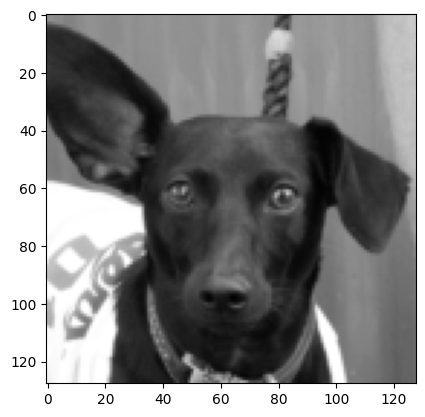

In [5]:
# get one item of dataloader
def get_one_item(dataloader):
    for data in dataloader:
        img = data[0][0][0]
        plt.imshow(img, cmap='gray')
        break
    return None

get_one_item(train_loader)

# AE


In [6]:
latent_dims = 128
num_epochs = 200
batch_size = 64
capacity = 16
learning_rate = 1e-3
use_gpu = True

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.encoder = nn.Sequential(
            nn.Conv2d(1, c, kernel_size=4, stride=2, padding=1),  # 128 → 64
            nn.BatchNorm2d(c),
            nn.ReLU(),

            nn.Conv2d(c, c * 2, kernel_size=4, stride=2, padding=1),  # 64 → 32
            nn.BatchNorm2d(c * 2),
            nn.ReLU(),

            nn.Conv2d(c * 2, c * 4, kernel_size=4, stride=2, padding=1),  # 32 → 16
            nn.BatchNorm2d(c * 4),
            nn.ReLU(),

            nn.Conv2d(c * 4, c * 8, kernel_size=4, stride=2, padding=1),  # 16 → 8
            nn.BatchNorm2d(c * 8),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(c * 8 * 8 * 8, latent_dims)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        return x_mu


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(latent_dims, c * 8 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(c * 8, c * 4, kernel_size=4, stride=2, padding=1),  # 8 → 16
            nn.BatchNorm2d(c * 4),
            nn.ReLU(),

            nn.ConvTranspose2d(c * 4, c * 2, kernel_size=4, stride=2, padding=1),  # 16 → 32
            nn.BatchNorm2d(c * 2),
            nn.ReLU(),

            nn.ConvTranspose2d(c * 2, c, kernel_size=4, stride=2, padding=1),  # 32 → 64
            nn.BatchNorm2d(c),
            nn.ReLU(),

            nn.ConvTranspose2d(c, 1, kernel_size=4, stride=2, padding=1),  # 64 → 128
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity * 8, 8, 8)
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu = self.encoder(x)
        x_recon = self.decoder(latent_mu)
        return x_recon, latent_mu

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def ae_loss(recon_x, x, mu):
    recon_loss = F.mse_loss(recon_x.view(-1, 128*128), x.view(-1, 128*128), reduction='sum')
    return recon_loss


In [8]:
def train_ae_gen(ae, sample_ae=False, sample_from=None):

  device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
  print(f'device: {device}')
  ae = ae.to(device)

  num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
  print('Number of parameters: %d' % num_params)

  optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate, weight_decay=1e-5)

  ae.train()

  train_loss_avg = []

  print('Training ...')
  for epoch in range(num_epochs+1):
      train_loss_avg.append(0)
      num_batches = 0
      if epoch % 10 == 0:
          torch.save(ae.state_dict(), f'ae_weights_{epoch}_latent_{latent_dims}_4layer_mse.pth')

      for image_batch, _ in train_loader:
          # stop at 20 batches
          # if num_batches >= 20:
          #     break

          image_batch = image_batch.to(device)

          if sample_ae:
            with torch.no_grad():
              # image_batch = image_batch.to(device)
              latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
              image_batch = sample_from.decoder(latent)

          # vae reconstruction
          image_batch_recon, latent_mu = ae(image_batch)

          # reconstruction error
          loss = ae_loss(image_batch_recon, image_batch, latent_mu)

          # backpropagation
          optimizer.zero_grad()
          loss.backward()

          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()

          train_loss_avg[-1] += loss.item()
          num_batches += 1

      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [9]:
# ae_init = Autoencoder()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# # vae_init.load_state_dict(torch.load("vae_weights.pth", map_location=device))
# ae_init = ae_init.to(device)

# num_params = sum(p.numel() for p in ae_init.parameters() if p.requires_grad)
# print('Number of parameters: %d' % num_params)

# train_ae_gen(ae_init, False, None)

In [10]:
ae = Autoencoder()
ae.load_state_dict(torch.load("ae_weights_200_latent_128_4layer_mse.pth", map_location=device))
ae.to(device)
ae.eval()  # Put in evaluation mode for inference

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    )
    (fc_mu): Linear(in_features=8192, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=8192, bias=True)
    (decoder): Sequential(
 

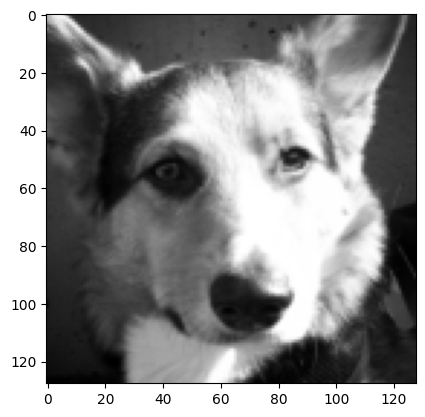

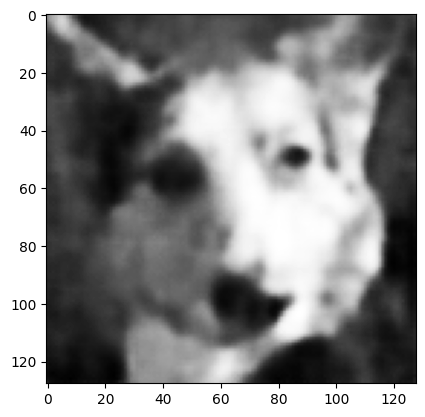

In [15]:
# sample one image from the dataset and its reconstruction from the vae

with torch.no_grad():
    for image_batch, _ in train_loader:
        image_batch = image_batch.to(device)
        image_batch_recon, _ = ae(image_batch)
        break

plt.imshow(image_batch[0][0].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(image_batch_recon[0][0].cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
# get all elements of class cat_s from the train dataset

def get_class_elements(dataloader, class_name):
    class_elements = []
    for data in dataloader:
        images, labels = data
        for i in range(len(labels)):
            if labels[i] == class_name:
                class_elements.append(images[i])
    return class_elements

cat_data = get_class_elements(train_loader, 0)
print(len(cat_data))
# get all elements of class dog_s from the train dataset
dog_data = get_class_elements(train_loader, 1)
print(len(dog_data))

In [ ]:
train_dataset.class_to_idx

In [ ]:
# get dog and cat data separately in two dataloaders
dog_loader = DataLoader(dog_data, batch_size=64, shuffle=True)
cat_loader = DataLoader(cat_data, batch_size=64, shuffle=True)

# get one item of dataloader
def get_one_item(dataloader):
    for data in dataloader:
        img = data[0][0]
        plt.imshow(img, cmap='gray')
        plt.show()
        break
    return None

get_one_item(dog_loader)
get_one_item(cat_loader)

In [ ]:
# collect encodings from autoencoder for dog and cat separately and make two numpy arrays

def get_encodings(dataloader):
    encodings_0 = []
    encodings_1 = []
    for data in dataloader:
        images, labels = data
        images = images.to(device)
        with torch.no_grad():
            _, latent_mu = ae(images)
        for i in range(len(labels)):
            if labels[i] == 0:
                encodings_0.append(latent_mu[i].cpu().numpy())
            else:
                encodings_1.append(latent_mu[i].cpu().numpy())
    return encodings_0, encodings_1

cat_encodings, dog_encodings = get_encodings(train_loader)
# convert to numpy arrays
cat_encodings = np.array(cat_encodings)
dog_encodings = np.array(dog_encodings)

print(cat_encodings.shape)
print(dog_encodings.shape)

# save the encodings to npz files
np.savez(train_dataset_path, cat=cat_encodings, dog=dog_encodings)

In [11]:
# open data from npz file

data = np.load(train_dataset_path)
cat_encodings = data['cat']
dog_encodings = data['dog']
print(cat_encodings.shape)
print(dog_encodings.shape)

(1000, 128)
(1000, 128)


In [12]:
from numpy.random import multivariate_normal

# fn for decorrelation and whitening

def decorr_white(X_0, X_1, final_shape):

    # compute means
    mean0 = np.mean(X_0, axis=0)
    mean1 = np.mean(X_1, axis=0)

    # Compute the covariance matrix
    cov0 = np.cov(X_0, rowvar=False)
    cov1 = np.cov(X_1, rowvar=False)

    # find eigenvalues and eigenvectors
    eigenvalues0, eigenvectors0 = np.linalg.eigh(cov0)
    eigenvalues1, eigenvectors1 = np.linalg.eigh(cov1)

    # Replace negative eigenvalues with very small constant
    eigenvalues0[eigenvalues0 < 0] = 1e-8
    eigenvalues1[eigenvalues1 < 0] = 1e-8
    
    # compute the square root of eigenvalues
    sqrt_eigenvalues0 = np.sqrt(eigenvalues0)
    sqrt_eigenvalues1 = np.sqrt(eigenvalues1)
    
    # Replace zero or negative eigenvalues on the diagonal with very small constant
    sqrt_eigenvalues0[sqrt_eigenvalues0 <= 0] = 1e-8
    sqrt_eigenvalues1[sqrt_eigenvalues1 <= 0] = 1e-8
    sqrt_eigenvalues0 = np.diag(sqrt_eigenvalues0)
    sqrt_eigenvalues1 = np.diag(sqrt_eigenvalues1)

    # invert sqrt of eigenvalues
    inv_sqrt_eigenvalues0 = np.linalg.inv(sqrt_eigenvalues0)
    inv_sqrt_eigenvalues1 = np.linalg.inv(sqrt_eigenvalues1)

    final_transform_0 = np.matmul(eigenvectors0, inv_sqrt_eigenvalues0)
    final_transform_1 = np.matmul(eigenvectors1, inv_sqrt_eigenvalues1)

    final_data_0 = np.matmul(X_0, final_transform_0)
    final_data_1 = np.matmul(X_1, final_transform_1)

    final_mean_0 = np.matmul(final_transform_0.T, mean0)
    final_mean_1 = np.matmul(final_transform_1.T, mean1)
    avg_mean = (final_mean_0 + final_mean_1)/2.0
    diff_mean = (final_mean_0 - final_mean_1)/2.0

    final_mean = np.array([100.0]*len(X_0[0]))

    final_data_0 = final_data_0 - diff_mean - avg_mean - final_mean
    final_data_1 = final_data_1 + diff_mean - avg_mean + final_mean

    final_cov_0 = np.cov(final_data_0, rowvar=False)
    final_cov_1 = np.cov(final_data_1, rowvar=False)

    # plot final covariance matrix
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.cov(final_data_0, rowvar=False), cmap='hot')
    plt.title('Final Covariance matrix of digit 0')
    plt.subplot(1, 2, 2)
    plt.imshow(np.cov(final_data_1, rowvar=False), cmap='hot')
    plt.title('Final Covariance matrix of digit 1')
    plt.colorbar()
    plt.show()
    plt.close()

    # sample random point to demonstrate reconstruction

    mean_0 = np.mean(final_data_0, axis=0)
    mean_1 = np.mean(final_data_1, axis=0)
    image_0 = multivariate_normal(mean_0, final_cov_0)
    image_1 = multivariate_normal(-mean_0, final_cov_0)

    inv_transform_0 = np.linalg.inv(final_transform_0)
    inv_transform_1 = np.linalg.inv(final_transform_1)
    image_0 = np.matmul((image_0 + avg_mean + diff_mean + final_mean), inv_transform_0) 
    image_1 = np.matmul((image_1 + avg_mean - diff_mean - final_mean), inv_transform_1)

    # pass through autoencoder
    image_0 = ae.decoder(torch.tensor(image_0).float().unsqueeze(0))
    image_1 = ae.decoder(torch.tensor(image_1).float().unsqueeze(0))

    # plot 
    plt.figure(figsize=(10, 5))
    plt.imshow(image_0.detach().reshape(final_shape[0], final_shape[1]), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.imshow(image_1.detach().reshape(final_shape[0], final_shape[1]), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

    return final_data_0, final_data_1, inv_transform_0, inv_transform_1, avg_mean, diff_mean, final_mean, final_cov_0


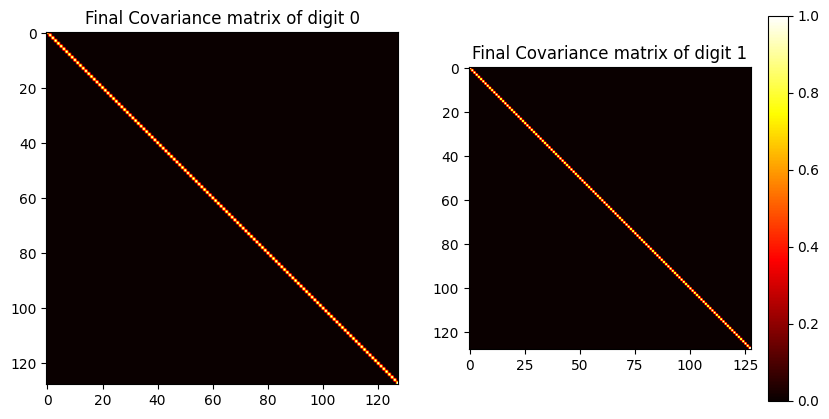

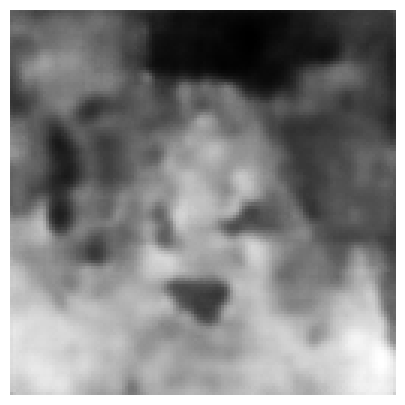

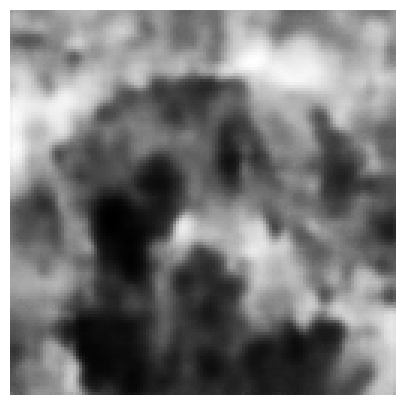

In [13]:
final_0_128, final_1_128, inv_0_128, inv_1_128, avg_mean_128, diff_mean_128, final_mean_128, final_cov_128 = decorr_white(cat_encodings, dog_encodings, (128, 128))

In [14]:
# generate a random variable which is + 1 or -1 with probability p or 1-p
def generate_random_variable(p):
    if np.random.rand() < p:
        return 1
    else:
        return -1

In [15]:
def generate_dataset_multivariate_gen(mu, var, p, num_samples, dim):
    # generate a dataset of 1000 samples of x = mu*generate_random_variable(p) + sigma*z
    x = []
    # cov = np.diag(var)
    std = np.sqrt(var)
    std_mat = np.diag(std)
    mu = np.array(mu)
    for i in range(num_samples):
        new_pt = mu*generate_random_variable(p) + np.matmul(std_mat, np.random.normal(0, 1, dim))
        x.append(new_pt)
    return torch.tensor(np.array(x))

In [16]:
def equations_d_dim_stable(vars, x_data):
    vars = torch.tensor(vars, dtype=torch.float64, device=x_data.device, requires_grad=False)
    n_val, d_val = x_data.shape
    mu_hat = vars[:-1]
    c_hat = torch.clamp(vars[-1], -50, 50)

    epsilon = 1e-5
    x2_col_sum = torch.sum(x_data ** 2, dim=0) / n_val
    var_hat = torch.clamp(x2_col_sum - mu_hat ** 2, min=epsilon)
    inv_var_hat = 1 / (var_hat + epsilon)

    s = torch.matmul(x_data * inv_var_hat, mu_hat)
    tanh_val = torch.tanh(torch.clamp(s + c_hat, -10, 10))

    eq1 = torch.sum(x_data * tanh_val.unsqueeze(1), dim=0) - n_val * mu_hat
    eq2 = torch.sum(tanh_val) - n_val * torch.tanh(c_hat)
    
    return torch.cat([eq1, eq2.unsqueeze(0)]).cpu()

In [17]:
from numpy.random import multivariate_normal

def sample_reconstruct(mean_arr, cov_arr, p_arr, idx_list, mean_tuple, inv_transform_0, inv_transform_1, final_shape):

    dim = len(mean_arr[0])

    avg_mean, diff_mean, final_mean = mean_tuple

    for idx in idx_list:
        mean = mean_arr[idx]
        var = cov_arr[idx]
        p = p_arr[idx]

        print(f'mean = {mean}')
        print(f'var = {var}')
        print(f'p = {p}')

        # sample and reconstruct 5 images as a subfigure
        fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True, sharey=True)

        image_list = generate_dataset_multivariate_gen(mean, var, p, 5, dim).numpy()
        for i in range(5):
            image = image_list[i]
            dist_metric = np.linalg.norm(image - final_mean) - np.linalg.norm(image + final_mean)
            digit = 0 if dist_metric > 0 else 1
            if digit == 0:
                image = np.matmul((image + avg_mean + diff_mean + final_mean), inv_transform_0)
            else:
                image = np.matmul((image + avg_mean - diff_mean - final_mean), inv_transform_1)
                
            image = ae.decoder(torch.tensor(image).float().unsqueeze(0)).detach().reshape(final_shape[0], final_shape[1])
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')

        plt.tight_layout()
        plt.title(f'Sample and Reconstruct for digit {digit} and epoch {idx}')
        plt.show()
        plt.close()


def plot_fn_mnist(mu_arr, var_arr, p_arr, mean_tuple, inv_transform_0, inv_transform_1, latent_dim, final_shape):

    # Create a figure for all mu dimensions
    fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

    axes = axes.flatten()

    factor = int(latent_dim/9)

    idx_list = [factor*i for i in range(8)]
    idx_list.append(-1)

    for i in range(9):
        ax = axes[i]  # Select the subplot axis
        for mu in mu_arr:
            ax.plot([row[idx_list[i]] for row in mu])
        ax.set_xlabel("Generation")
        ax.set_ylabel(fr"$\widehat{{\mu}}_{{{idx_list[i]}, \mathrm{{ML}}}}$")
        # set y from -4 to 4
        # ax.set_ylim(-1, 1.5)
        ax.set_title(fr"Estimated $\mu_{{{idx_list[i]}}}$")
        ax.legend()

    fig.tight_layout()
    plt.show(fig)
    plt.savefig('mnist_mu.png')
    plt.close(fig)

    # Separate figures for sigma and p
    # Sigma
    # Create a figure for all mu dimensions
    fig_1, axes_1 = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

    axes_1 = axes_1.flatten()

    for i in range(9):
        ax1 = axes_1[i]  # Select the subplot axis
        for var in var_arr:
            ax1.plot([var_row[idx_list[i]] for var_row in var])
        ax1.set_xlabel("Generation")
        ax1.set_ylabel(fr"$\widehat{{\sigma}}_{{{idx_list[i]}, \mathrm{{ML}}}}$")
        # ax1.set_ylim(-1, 1.5)
        ax1.set_title("Estimated var")
        ax1.legend()

    fig_1.tight_layout()
    plt.show(fig_1)
    plt.savefig('mnist_sigma.png')
    plt.close()

    # Probabilities
    plt.figure(figsize=(7, 5))
    for p_vals in p_arr:
        sns.lineplot(data=np.array(p_vals))
    plt.xlabel("Generation")
    plt.ylabel(r"$\widehat{p}_{ML}$")
    plt.title("Estimated Probabilities")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig('mnist_p.png')
    plt.close()

    test_idx = np.random.randint(0, len(mu_arr))
    test_mu_traj = mu_arr[test_idx]
    test_var_traj = var_arr[test_idx]
    test_p_traj = p_arr[test_idx]
    idx_list = np.arange(0, len(test_mu_traj) - 1, len(test_mu_traj)//10)
    idx_list = np.append(idx_list, len(test_mu_traj) - 1)
    print(f'idx_list = {idx_list}')
    sample_reconstruct(test_mu_traj, test_var_traj, test_p_traj, idx_list, mean_tuple, inv_transform_0, inv_transform_1, final_shape)
    # sample_reconstruct(test_mu_traj, test_var_traj, 1, idx_list, mean_tuple, inv_transform_1, final_shape)


In [23]:
def mnist_exp(x_data, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, mean_tuple, inv_transform_0, inv_transform_1, final_shape, latent_dim, add_old_data=0):
    for mu_0 in mu_0_vals:
        for var_0 in var_0_vals:
            for p_0 in p_0_vals:
                pbar1 = tqdm(total=num_trajectories * num_generations)
                mu_arr, var_arr, p_arr = [], [], []
                
                for _ in range(num_trajectories):
                    mu, var, p = [mu_0], [var_0], [p_0]
                    
                    for i in range(1, num_generations + 1):
                        if i == 1:
                            print(f'Generation {i}')
                        Y = torch.tensor(x_data) if i == 1 else generate_dataset_multivariate_gen(mu[-1], var[-1], p[-1], n, dim).to(device)

                        if add_old_data > 0 and i > 1:
                            # shuffle old data and add it to the new data
                            old_data = x_data[torch.randperm(x_data.shape[0])]
                            old_data = old_data[:add_old_data]
                            Y = torch.cat([Y, torch.tensor(old_data).to(device)], dim=0)

                        n = Y.shape[0]
                        
                        init_guess = torch.tensor([7.0]*(dim) + [0.2], device=device) + torch.randn(dim + 1, device=device)
                        soln_vals = torch.tensor(sopt.least_squares(lambda vars: equations_d_dim_stable(vars, Y), x0 = init_guess).x)
                        # soln_vals = torch.linalg.lstsq(equations_d_dim_stable(init_guess, Y)).solution
                        
                        y2_data = torch.clamp(Y, min=-1e8, max=1e8) ** 2
                        var_hat = torch.sum(y2_data, axis=0) / n - soln_vals[:-1] ** 2
                        var_hat = torch.clamp(var_hat, min=1e-5, max=1e5)
                        
                        if (torch.abs(soln_vals[:-1]) > 1e3).any():
                            print(f'Overflow in mu: {soln_vals[:-1]}')
                            break
                        
                        mu.append(soln_vals[:-1])
                        var.append(var_hat)
                        p.append(torch.sigmoid(soln_vals[-1]))
                        
                        pbar1.update(1)
                    
                    mu_arr.append(mu)
                    var_arr.append(var)
                    p_arr.append(p)
                
                plot_fn_mnist(mu_arr, var_arr, p_arr, mean_tuple, inv_transform_0, inv_transform_1, latent_dim, final_shape)
                pbar1.close()


(100, 128)


  0%|          | 0/3000 [00:00<?, ?it/s]

Generation 1


  0%|          | 1/3000 [00:00<37:06,  1.35it/s]C:\Users\shrey\AppData\Local\Temp\ipykernel_21656\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
100%|██████████| 3000/3000 [38:43<00:00,  1.11it/s]C:\Users\shrey\AppData\Local\Temp\ipykernel_21656\1100795496.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


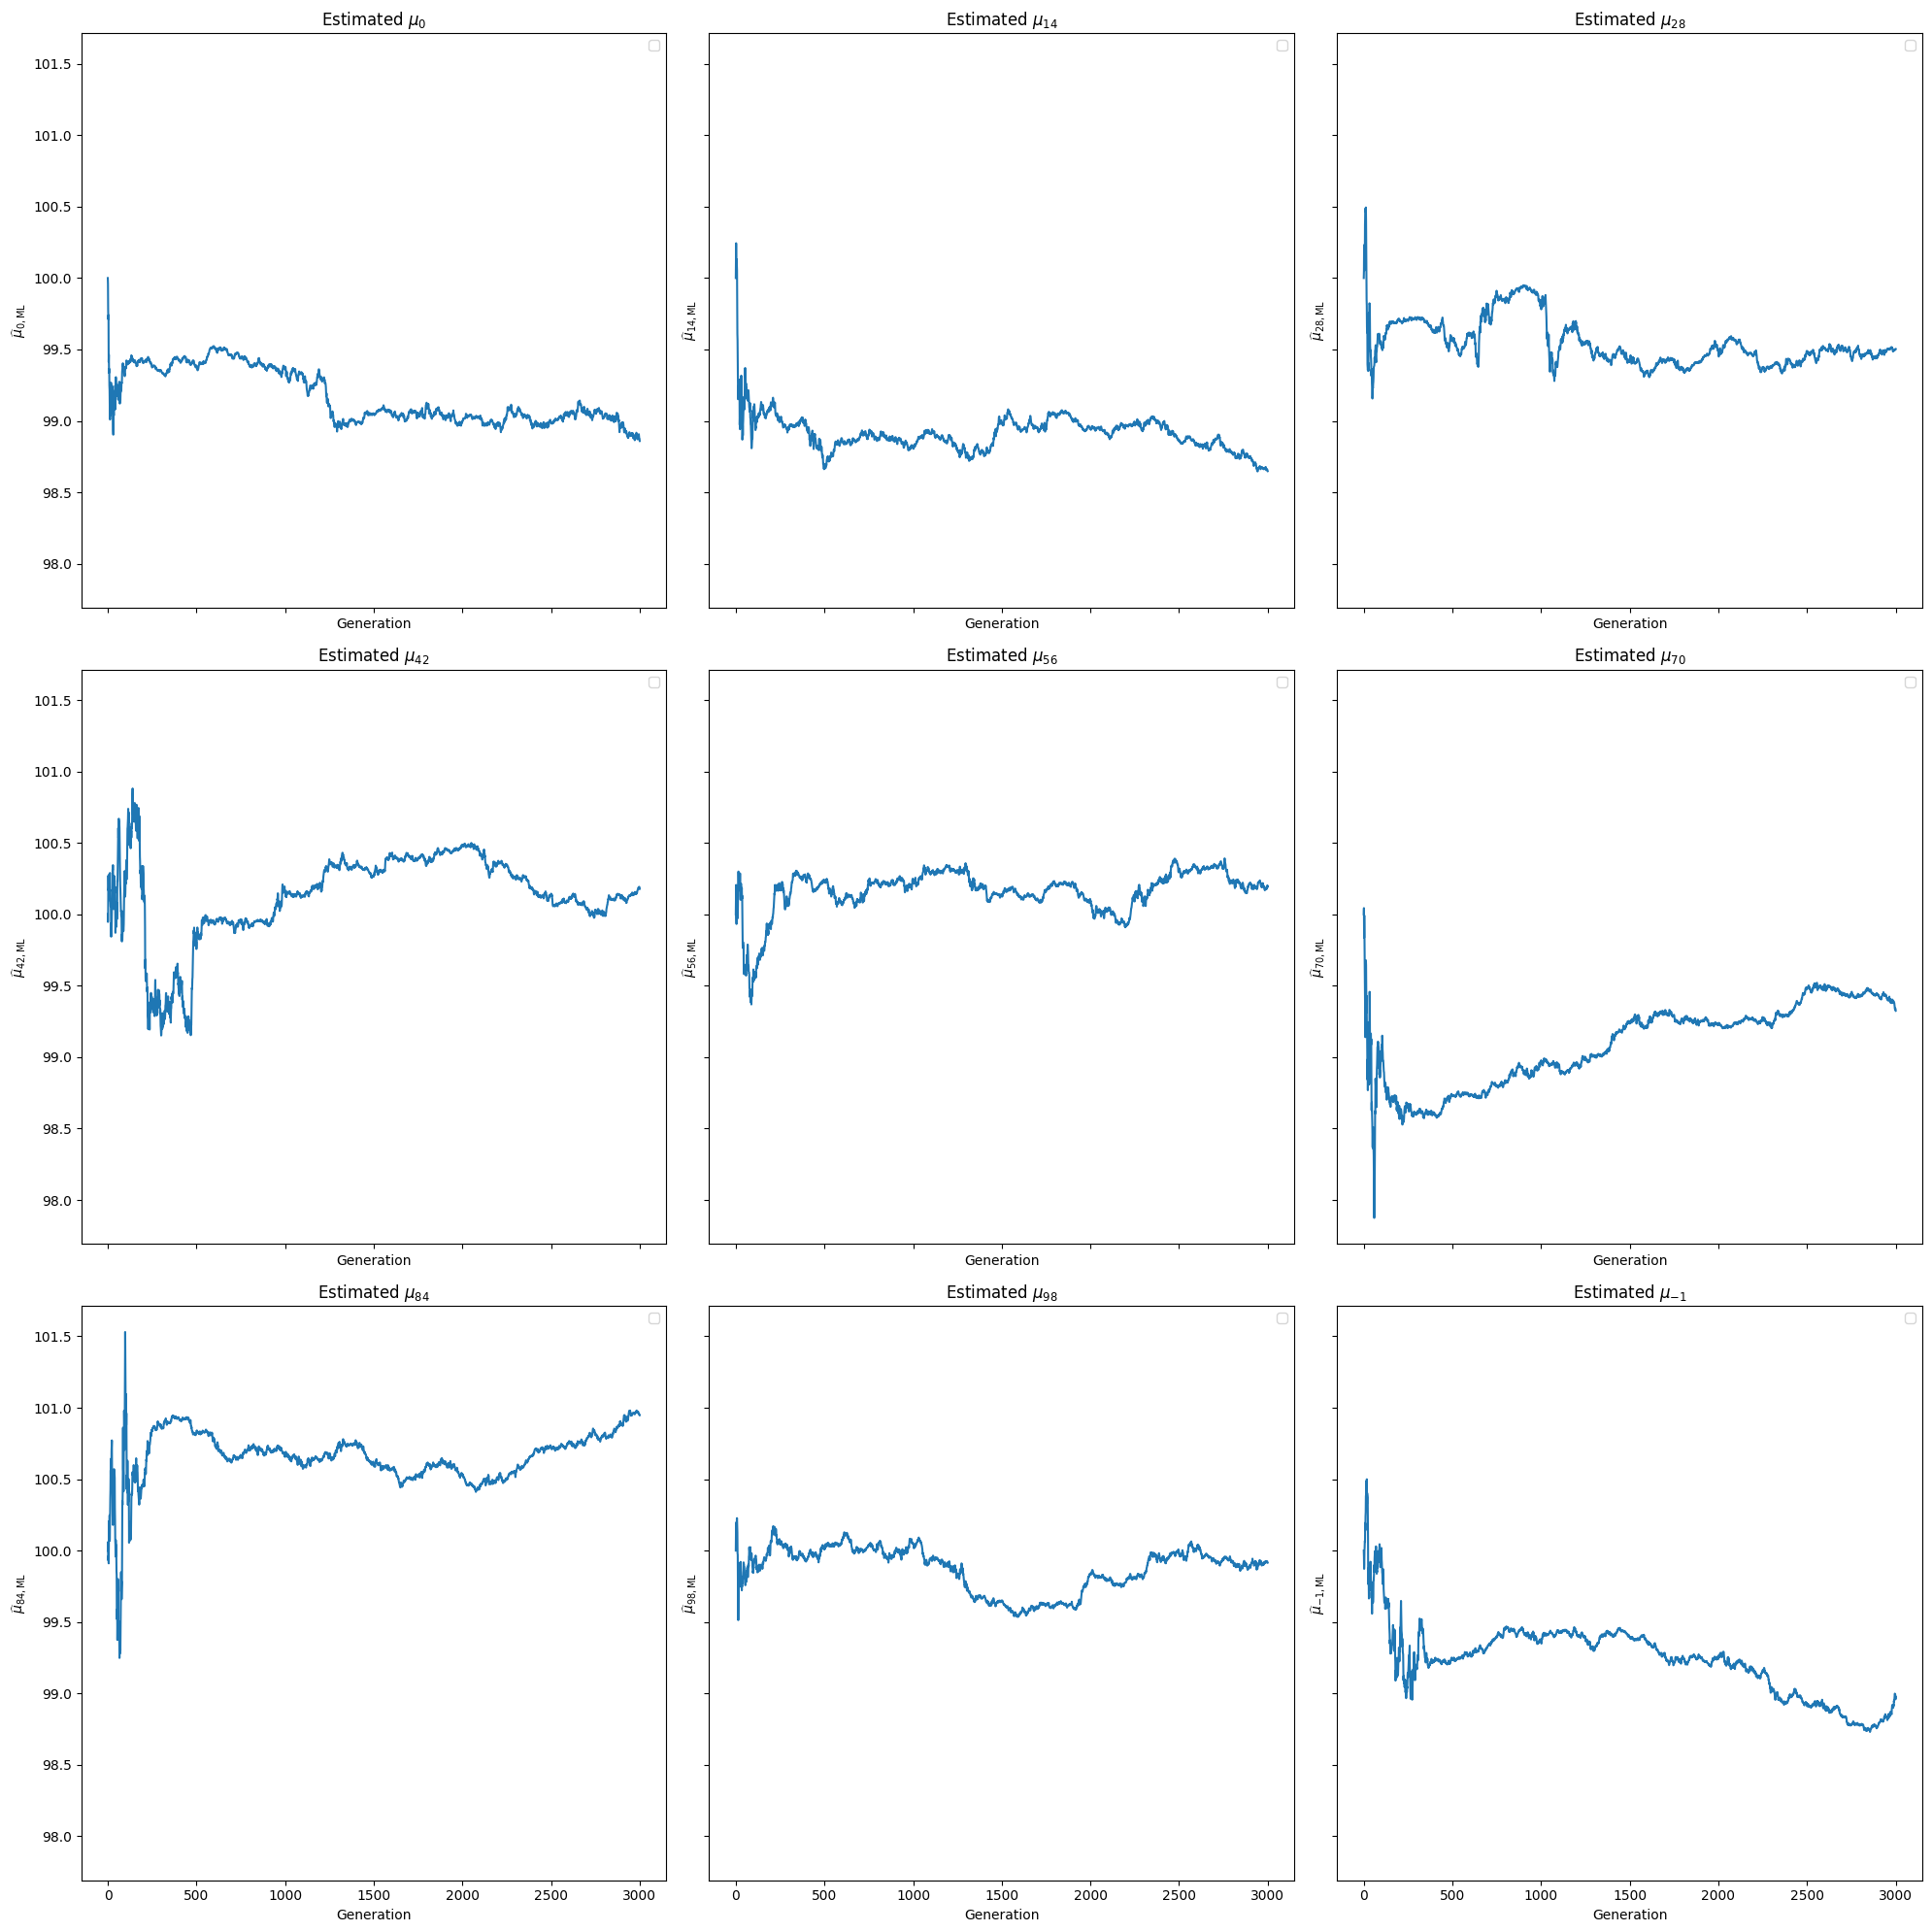

C:\Users\shrey\AppData\Local\Temp\ipykernel_21656\1100795496.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

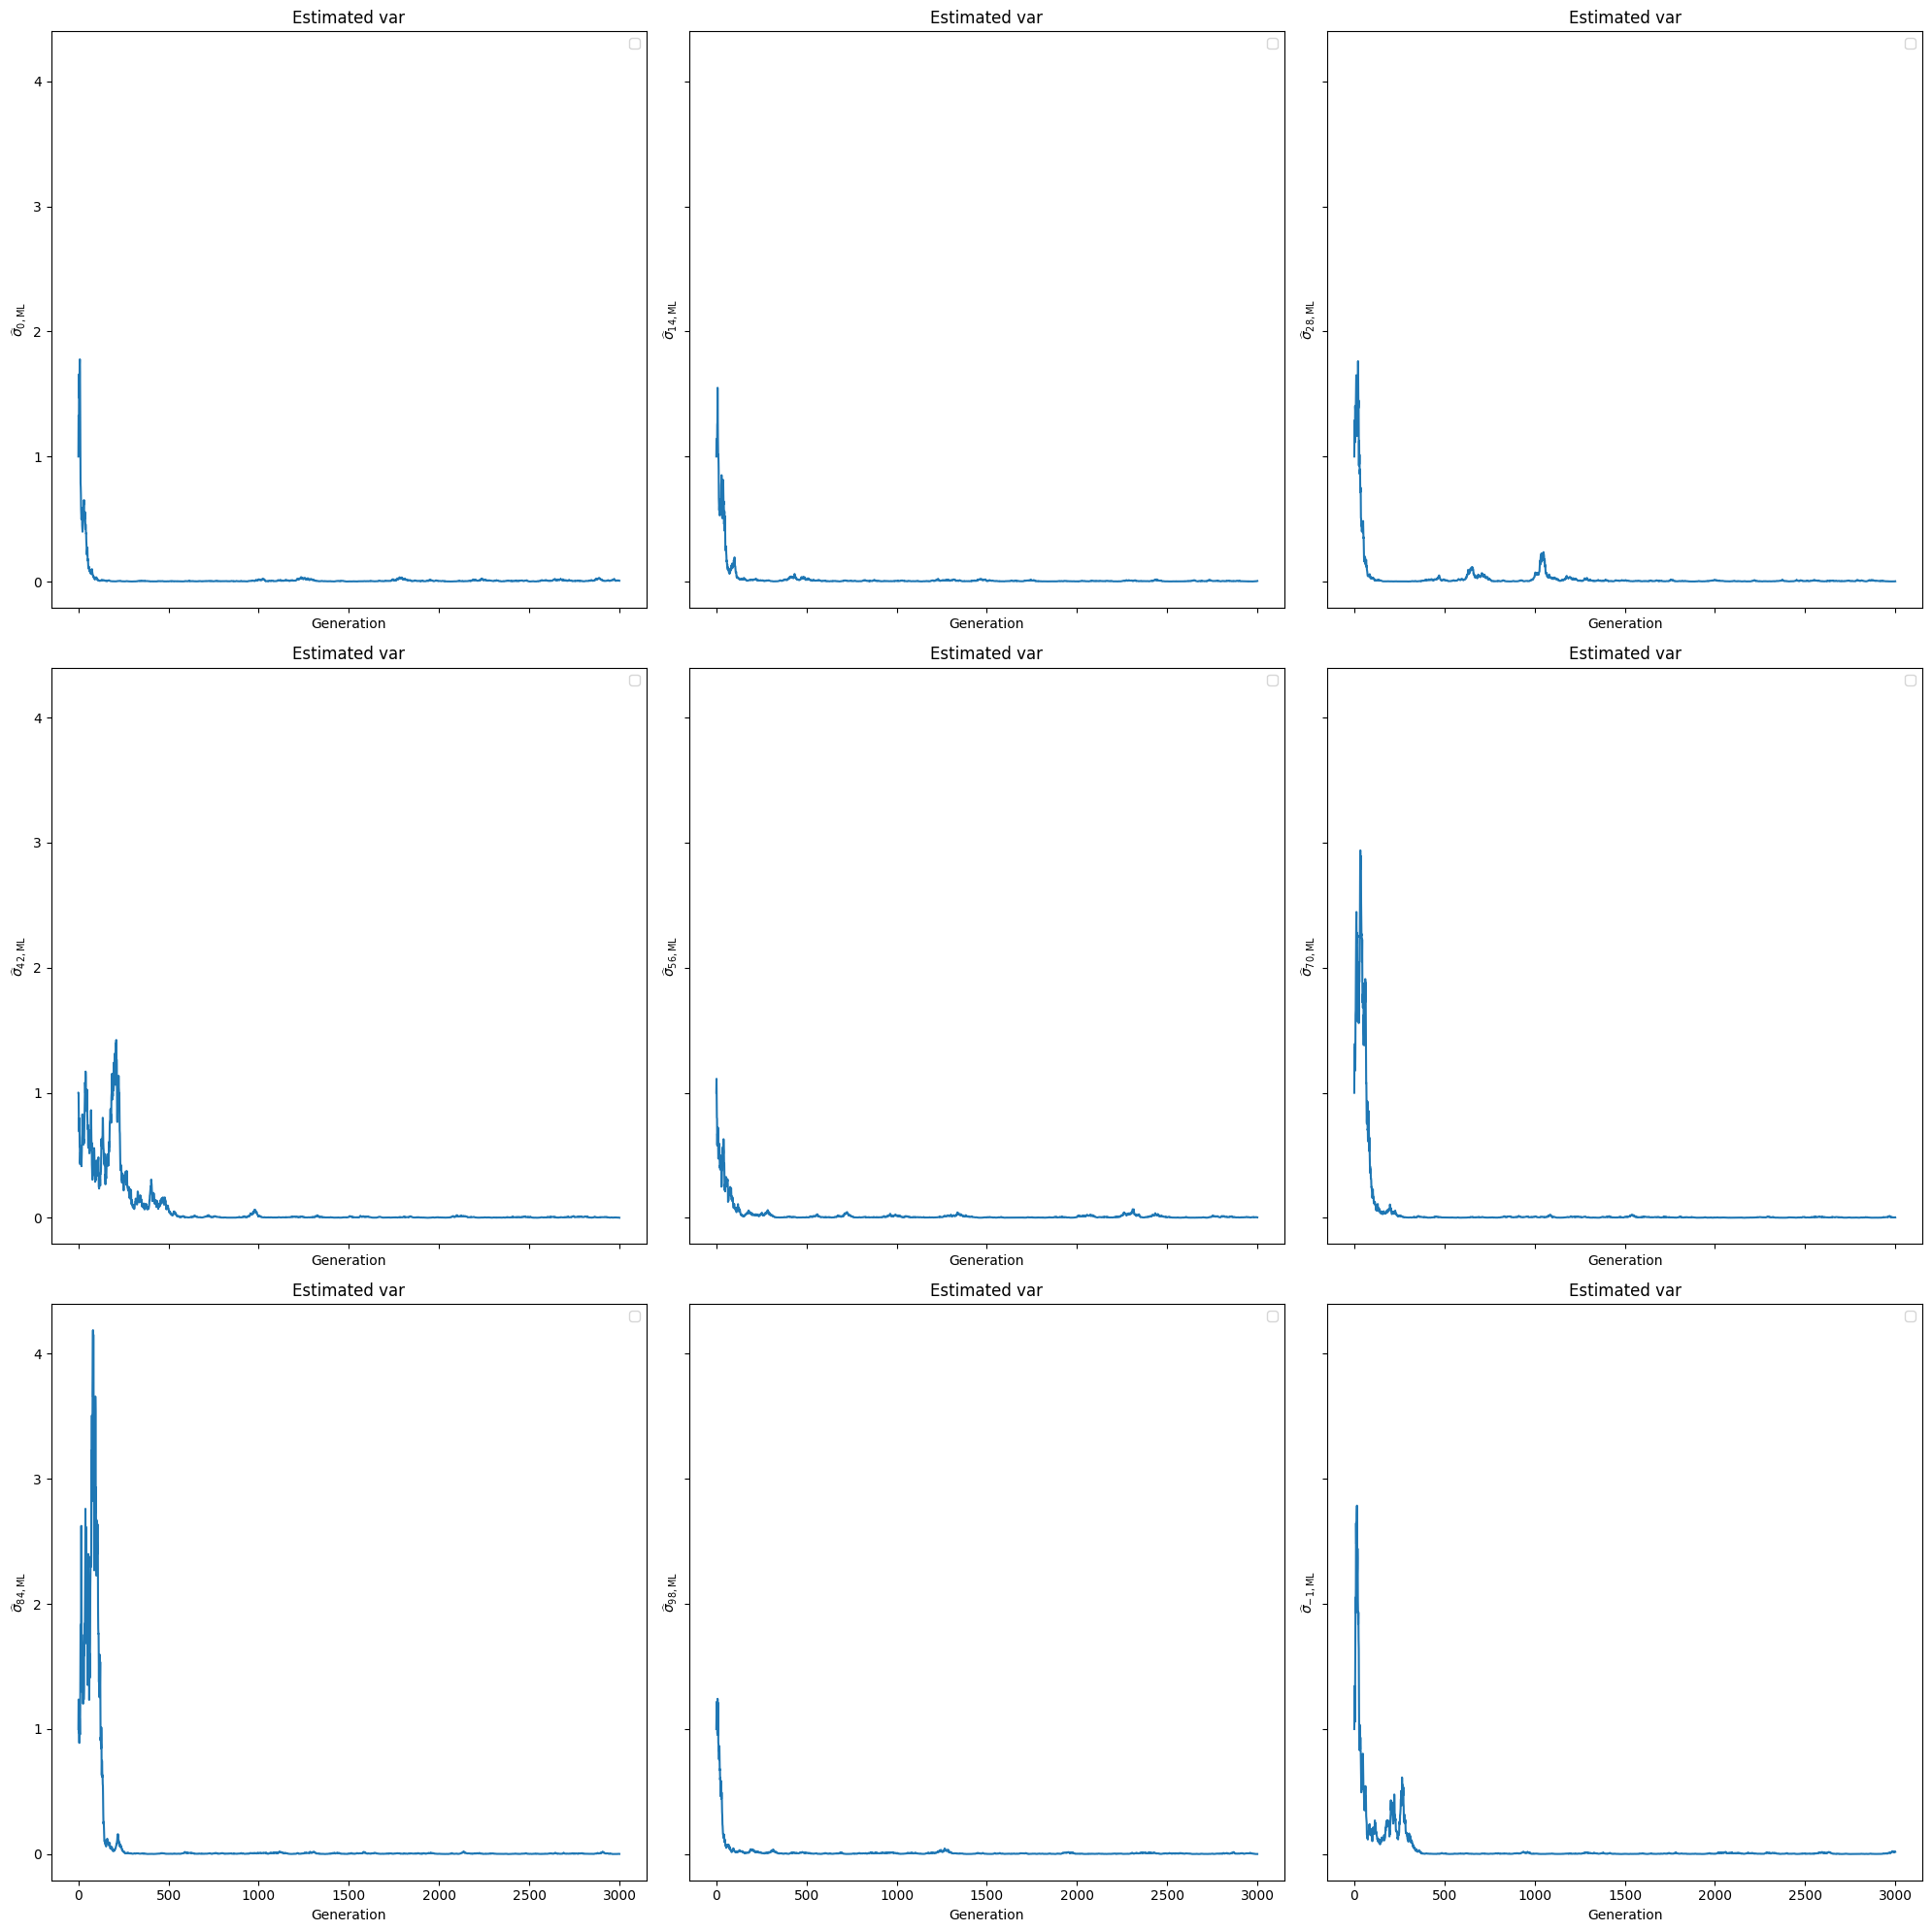

C:\Users\shrey\AppData\Local\Temp\ipykernel_21656\1100795496.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


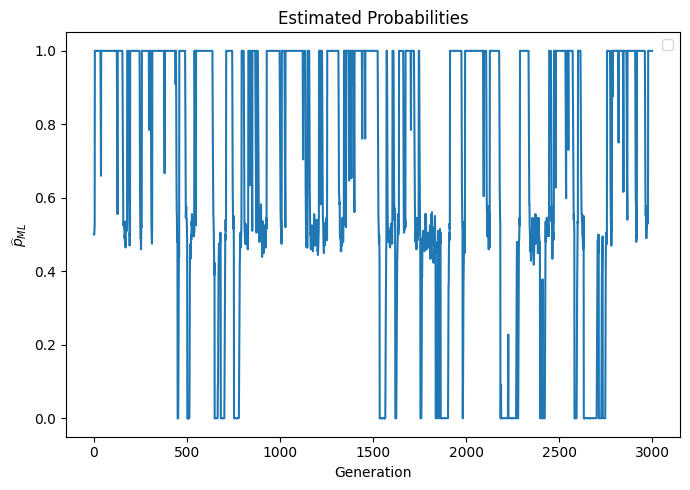

idx_list = [   0  300  600  900 1200 1500 1800 2100 2400 2700 3000]
mean = tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100.])
var = tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

C:\Users\shrey\AppData\Local\Temp\ipykernel_21656\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)


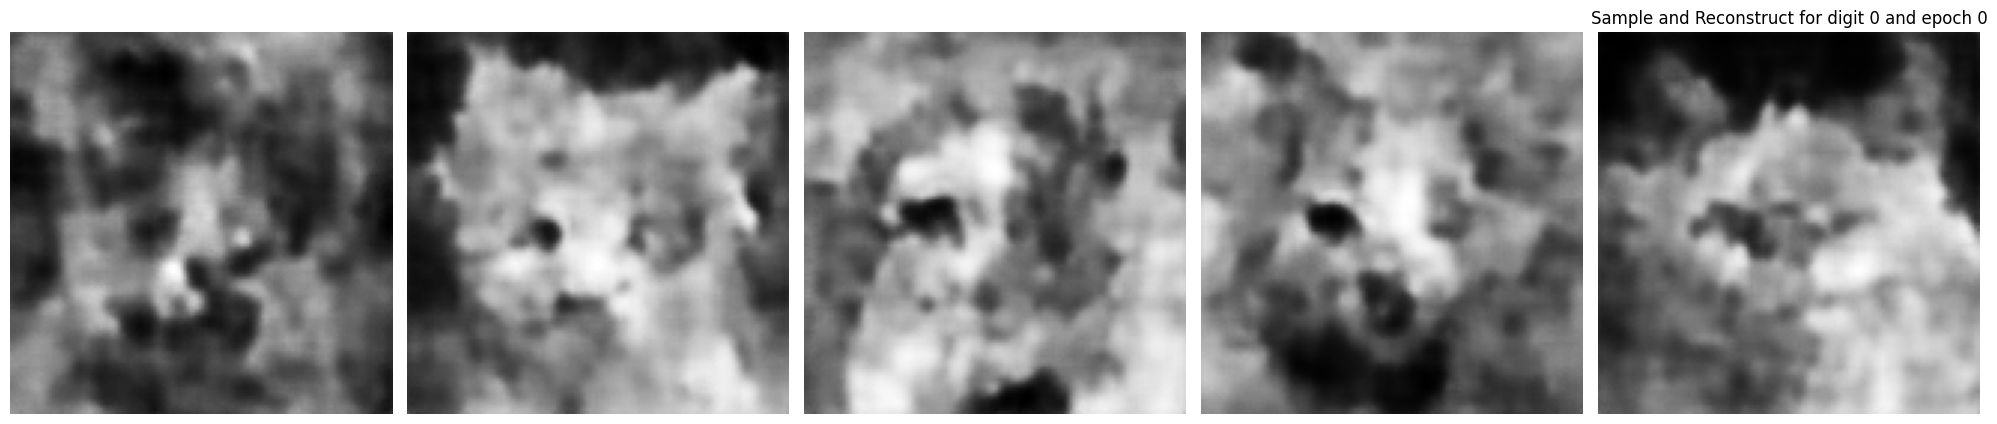

mean = tensor([ 99.3546, 101.4850, 100.8735,  99.6593, 101.5412,  99.2704, 101.6478,
         97.5489,  97.5829, 100.3602,  99.1842, 102.3326,  99.7941, 101.0372,
         98.9465,  98.2046,  99.4141, 100.8605, 100.6403, 101.2112,  97.1136,
        100.1842,  99.9544, 101.2330,  98.6688,  99.8470, 100.2046,  99.4997,
         99.7171, 101.2307, 100.5775,  99.6473, 100.3680,  99.2170, 100.1451,
        101.0356,  99.5733,  99.3561, 100.0718,  99.7504, 100.1414, 101.0732,
         99.1727, 101.5209,  99.9137, 100.3322,  98.7580, 100.3481, 100.0559,
         99.8841,  99.2229,  99.8843,  99.8610, 100.6351,  99.4672, 102.6193,
        100.0753,  99.3359,  99.8220,  99.1934, 101.2302, 101.9952, 100.4032,
        100.7394,  98.0197,  99.4478,  99.7600,  99.7410,  99.6158,  99.8668,
         98.6105,  99.9119,  99.2594, 102.2142,  99.2613, 100.5684,  99.5153,
        101.8408, 100.6280, 101.0397, 100.8830,  98.6510, 100.8377,  97.7362,
        100.8811,  99.0858,  99.3410, 100.4484,  98.4799,

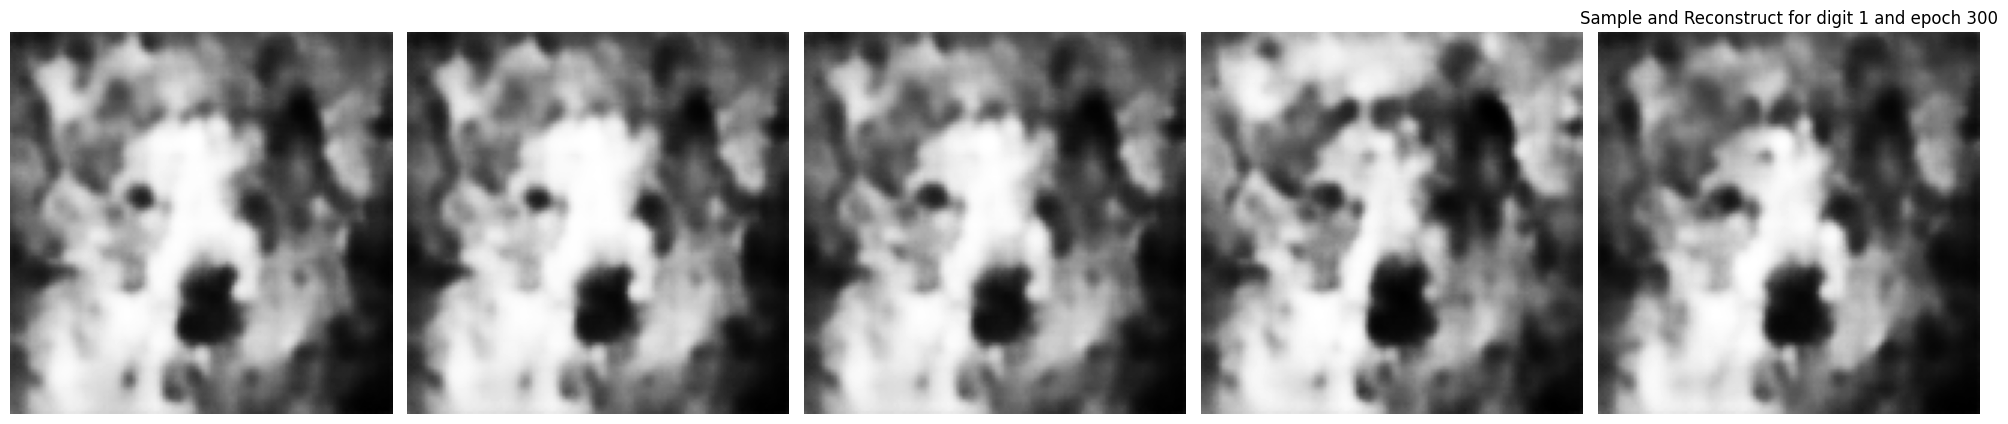

mean = tensor([ 99.5178, 100.8547, 100.9931,  99.6394, 101.6952,  98.9685, 101.7230,
         97.4676,  97.6376, 100.3468,  99.2678, 101.9033,  99.3711, 101.2799,
         98.8568,  98.3727,  99.3517, 100.4546, 100.4896, 100.9724,  97.1273,
        100.3617, 100.0814, 100.9536,  98.5333,  99.6313, 100.2211,  99.5247,
         99.6001, 101.1695, 100.6322,  99.5399, 100.3491,  98.9897, 100.0083,
        101.0174,  99.3553,  99.2322,  99.9826,  99.8171, 100.2773, 101.2261,
         99.9364, 101.7709,  99.8397, 100.3525,  98.6266, 100.0117,  99.8047,
         99.7434,  99.2117,  99.9798,  99.7140, 100.6535,  99.2777, 102.6682,
        100.0638,  99.9465,  99.9234,  99.2391, 101.4262, 101.9497, 100.4431,
        100.7334,  98.1184,  99.4111,  99.4608, 100.0221,  99.5307,  99.6924,
         98.7318,  99.8042,  99.3277, 101.9943,  99.3176, 100.6073,  99.3468,
        101.7198, 100.6242, 100.7694, 100.9536,  98.7502, 100.8893,  97.8474,
        100.7830,  99.2378,  99.5593, 100.2789,  98.6127,

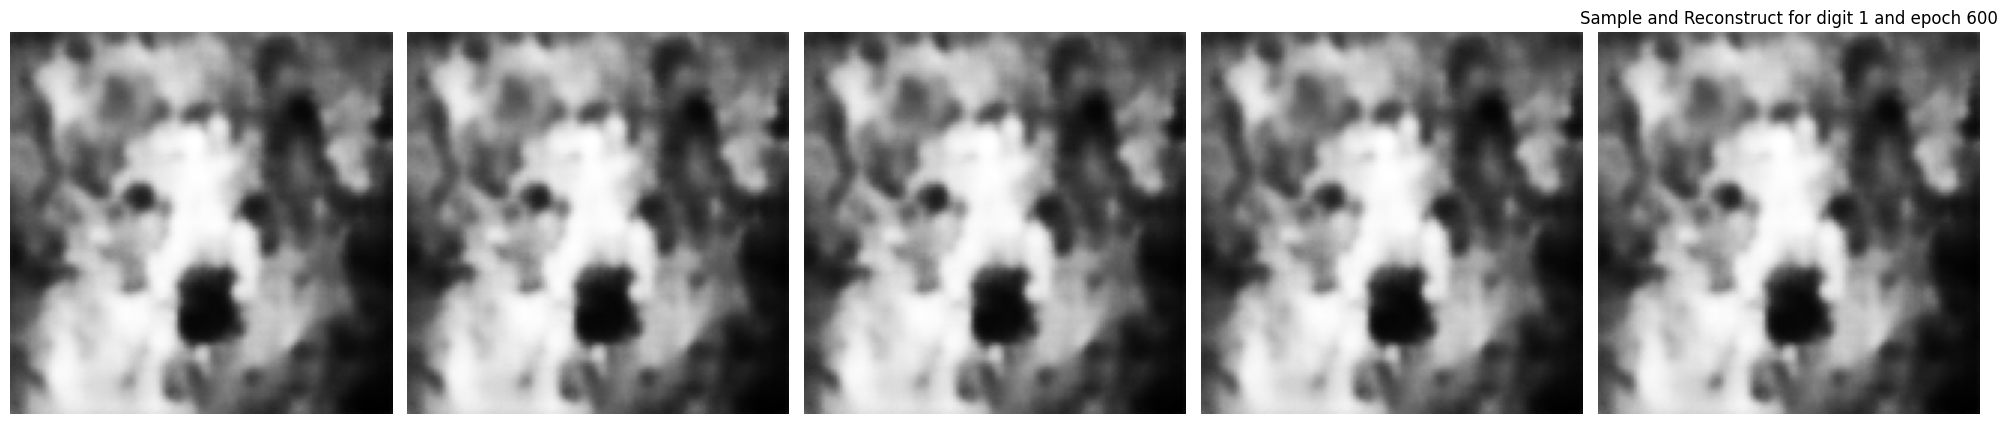

mean = tensor([ 99.3697, 100.9631, 101.0854,  99.6826, 101.6981,  99.0531, 101.7351,
         97.3438,  97.9614, 100.3765,  99.1875, 102.1914,  99.6797, 101.2747,
         98.8689,  98.2859,  99.3725, 100.7725, 100.6978, 101.0227,  97.5056,
        100.3964, 100.0574, 101.1369,  98.5560,  99.7782,  99.9978,  99.2212,
         99.9502, 101.1690, 100.8317,  99.4216, 100.3665,  99.2393, 100.2457,
        101.0966,  99.2336,  99.2326,  99.6045,  99.7008, 100.4441, 101.2645,
         99.9210, 101.8436, 100.0815, 100.5614,  98.7330,  99.9611,  99.7445,
         99.6323,  99.1869,  99.8292,  99.6290, 100.7094,  99.4086, 102.7730,
        100.2125, 100.0461,  99.9480,  99.0557, 101.5667, 102.1521, 100.2928,
        100.8231,  97.9542,  99.2385,  99.5245, 100.0696,  99.8970,  99.7442,
         98.9046,  99.6382,  99.7730, 101.9614,  99.4860, 100.7541,  99.1912,
        101.9935, 101.0008, 101.1049, 100.9297,  98.5278, 100.7532,  97.7162,
        100.7221,  99.2377,  99.4707, 100.2543,  98.6641,

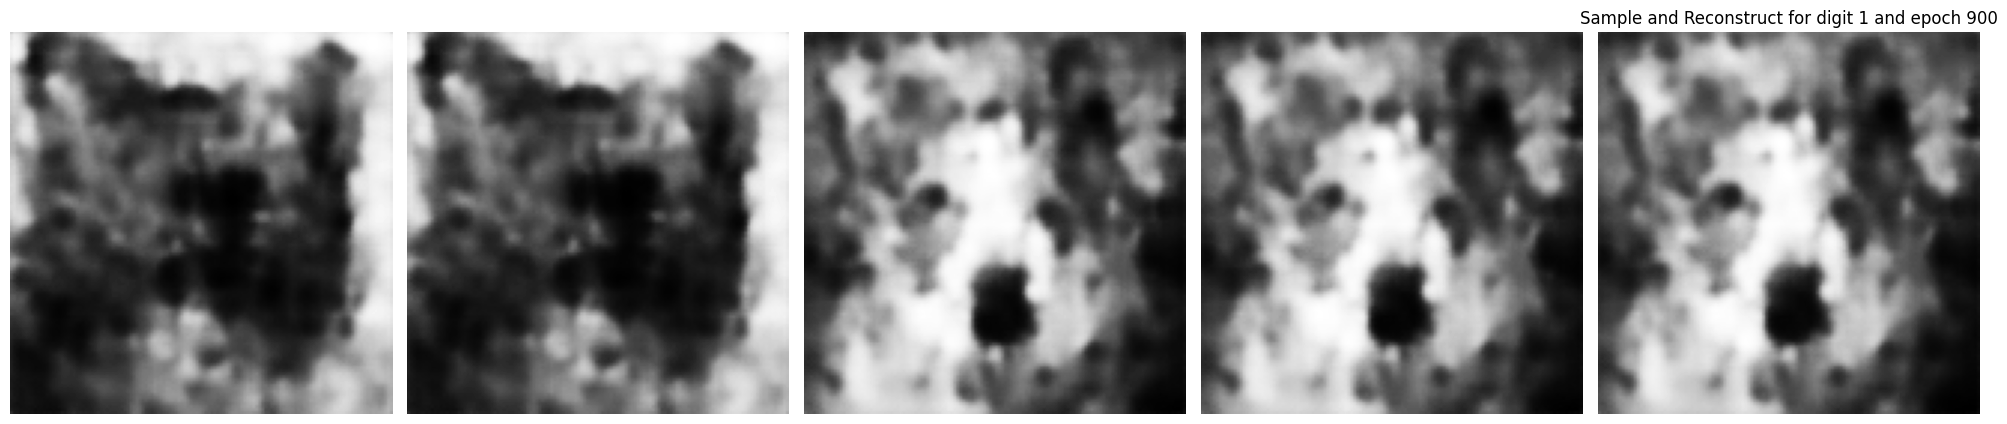

mean = tensor([ 99.2896, 101.1262, 100.9107,  99.7311, 101.7413,  99.1798, 102.0450,
         97.3898,  97.8846, 100.2564,  99.0854, 102.1216,  99.8157, 101.4056,
         98.8975,  98.3757,  99.6056, 100.4285, 100.5015, 101.4553,  97.2012,
        100.3188, 100.0540, 101.3115,  98.5752,  99.8252,  99.9683,  99.0146,
         99.6542, 101.3748, 101.1786,  99.5065, 100.4518,  99.3134, 100.1782,
        101.3845,  99.3008,  99.1247,  99.8173,  99.7722, 100.4207, 101.4346,
        100.2088, 101.8510, 100.0208, 100.3886,  98.6447,  99.8846,  99.9591,
         99.5168,  99.1036,  99.7699,  99.4184, 101.0549,  99.2210, 102.7219,
        100.3329,  99.9621,  99.9902,  99.2286, 101.7621, 102.1689, 100.1171,
        100.7027,  97.9666,  99.0499,  99.4215,  99.8651, 100.0863,  99.4857,
         98.9488,  99.7154,  99.8721, 102.0173,  99.3523, 100.7354,  99.1344,
        101.8172, 100.7239, 101.0386, 100.8774,  99.0422, 100.8657,  97.6066,
        100.6283,  99.1425,  99.2447, 100.5891,  98.2433,

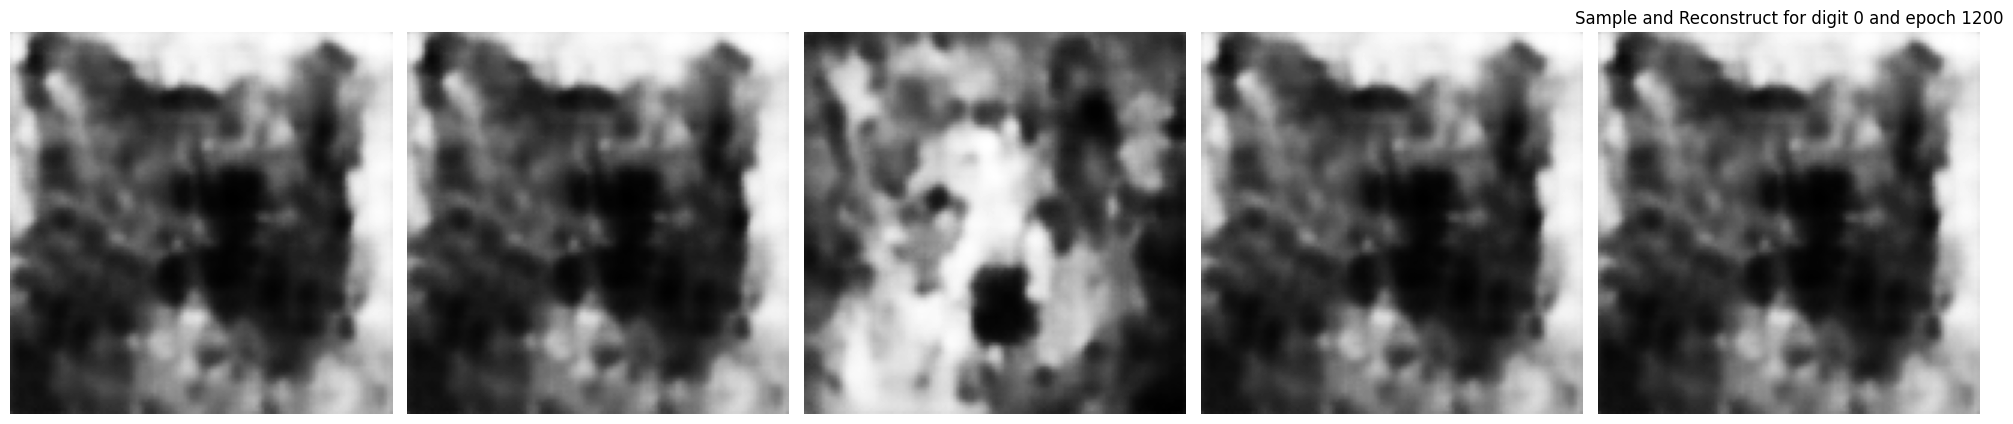

mean = tensor([ 99.0484, 101.0029, 101.1062,  99.8116, 101.5735,  99.2045, 102.0363,
         97.2188,  98.0987, 100.4774,  99.4652, 102.1401,  99.4458, 101.3797,
         98.9815,  98.3300,  99.6060, 100.4405, 100.5264, 101.5107,  97.1916,
        100.3285, 100.0633, 101.3733,  98.5049, 100.0991, 100.1885,  99.3617,
         99.4315, 101.3696, 101.1788,  99.5513, 100.3733,  99.4008, 100.1416,
        101.3932,  99.3679,  99.2138, 100.0912,  99.7266, 100.4131, 101.4032,
        100.2745, 102.0606, 100.1135, 100.6663,  98.8363,  99.8333,  99.8598,
         99.6435,  99.4544,  99.6810,  99.4947, 101.2607,  99.1599, 102.7527,
        100.1339,  99.9231,  99.8833,  99.2979, 101.9357, 102.0946,  99.7706,
        100.5905,  98.0292,  99.0629,  99.3686,  99.5348, 100.1115,  99.3566,
         99.2350,  99.8495,  99.8195, 102.0766,  98.9898, 100.6538,  99.0109,
        101.5681, 101.0333, 101.0166, 100.8625,  99.3214, 100.9907,  97.8724,
        100.6067,  99.1214,  99.2221, 100.8105,  98.3684,

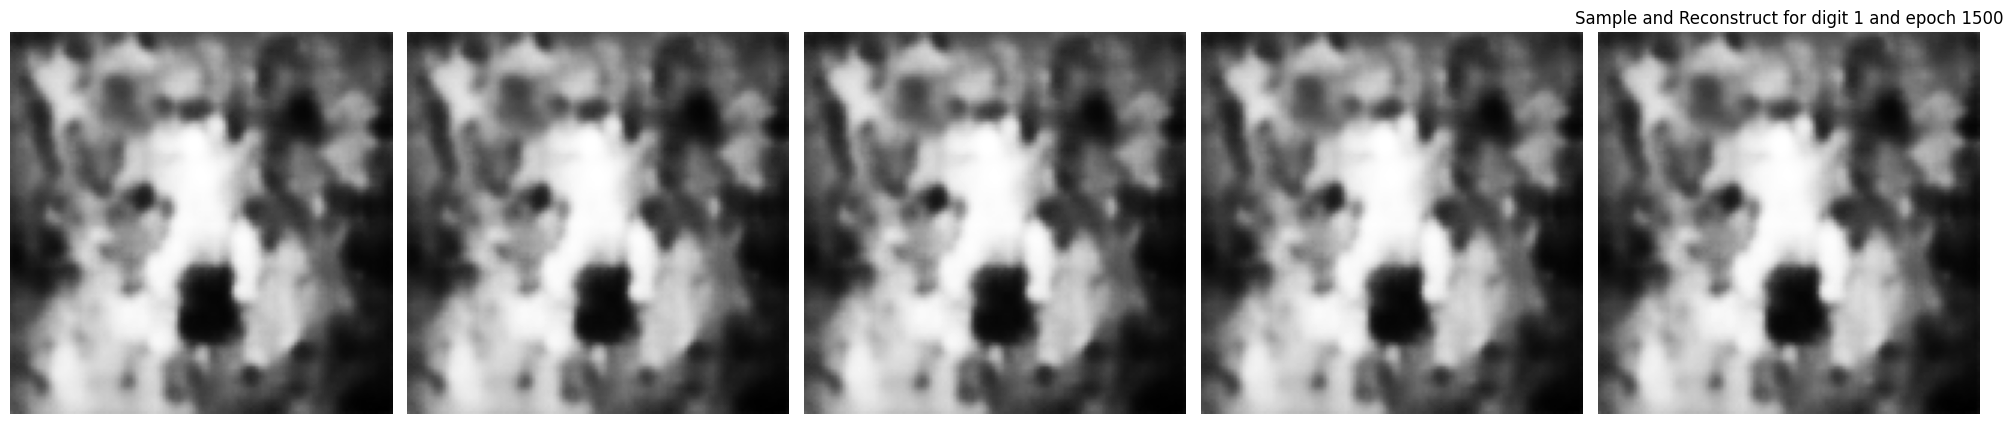

mean = tensor([ 99.0849, 101.1236, 101.1167, 100.0665, 101.6826,  99.1512, 101.8752,
         97.1029,  98.3961, 100.3568,  99.4981, 101.8988,  99.6553, 101.5628,
         99.0520,  98.2051,  99.5726, 100.5463, 100.7959, 101.6464,  96.9022,
        100.4899,  99.9038, 101.1983,  98.3564, 100.3216, 100.1682,  99.2404,
         99.3707, 101.3929, 101.2165,  99.6228, 100.4174,  99.3077,  99.9965,
        101.4814,  99.4607,  99.1508, 100.4677,  99.6804, 100.4701, 101.2418,
        100.3620, 102.1944, 100.1566, 100.7332,  98.9001,  99.7485,  99.7641,
         99.6985,  99.5205,  99.6771,  99.6622, 101.3125,  99.2975, 102.7464,
        100.2168, 100.0956, 100.0143,  99.3231, 101.8176, 102.1646,  99.7484,
        100.4898,  97.9122,  98.9063,  99.5435,  99.8980, 100.2307,  99.4605,
         99.2528,  99.7705,  99.8971, 101.7251,  98.9132, 100.4521,  99.1945,
        101.7169, 101.0474, 101.1143, 101.0561,  99.4551, 100.8542,  97.8277,
        100.6053,  99.3035,  99.1720, 100.7632,  98.3696,

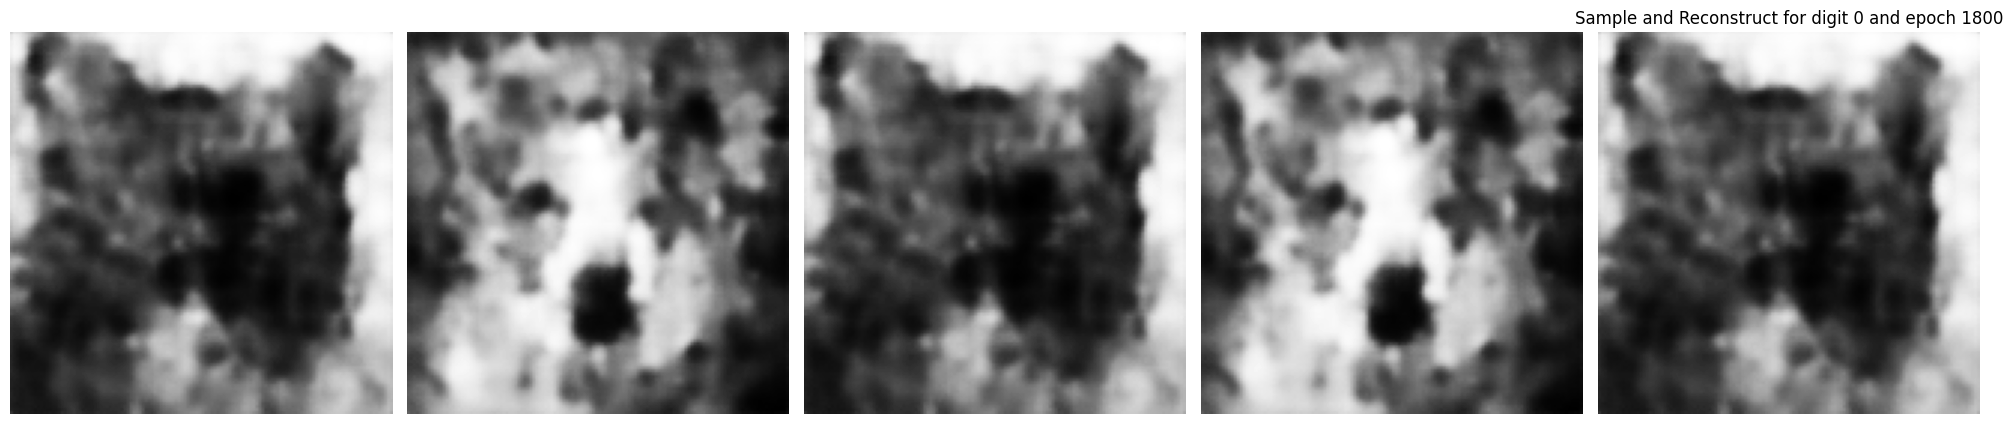

mean = tensor([ 99.0168, 101.1087, 101.2957, 100.0982, 101.3980,  99.0433, 101.7433,
         97.1242,  98.2989, 100.4253,  99.6082, 101.7572,  99.7084, 101.6207,
         98.9089,  98.4661,  99.3934, 100.4978, 100.7042, 101.7507,  96.9855,
        100.7700,  99.8654, 101.2410,  98.4856, 100.2259, 100.2307,  99.2155,
         99.5495, 101.2346, 101.4241,  99.5305, 100.4763,  99.4250,  99.8330,
        101.5386,  99.5081,  99.0535, 100.5373,  99.5290, 100.5747, 101.1755,
        100.4250, 102.1700, 100.1281, 100.7769,  98.8616,  99.6712,  99.8743,
         99.5885,  99.5156,  99.6798,  99.8321, 101.1754,  99.4748, 102.7503,
        100.0299, 100.1224,  99.9528,  99.1896, 101.9492, 102.3511,  99.8015,
        100.7950,  98.1161,  98.7595,  99.4423,  99.6318, 100.2362,  99.1907,
         99.2346,  99.7108,  99.9875, 101.8684,  98.8911, 100.3516,  99.2910,
        101.6944, 100.9347, 101.3364, 100.8722,  99.4680, 100.6785,  97.8992,
        100.4500,  99.4190,  99.2598, 100.6229,  98.3678,

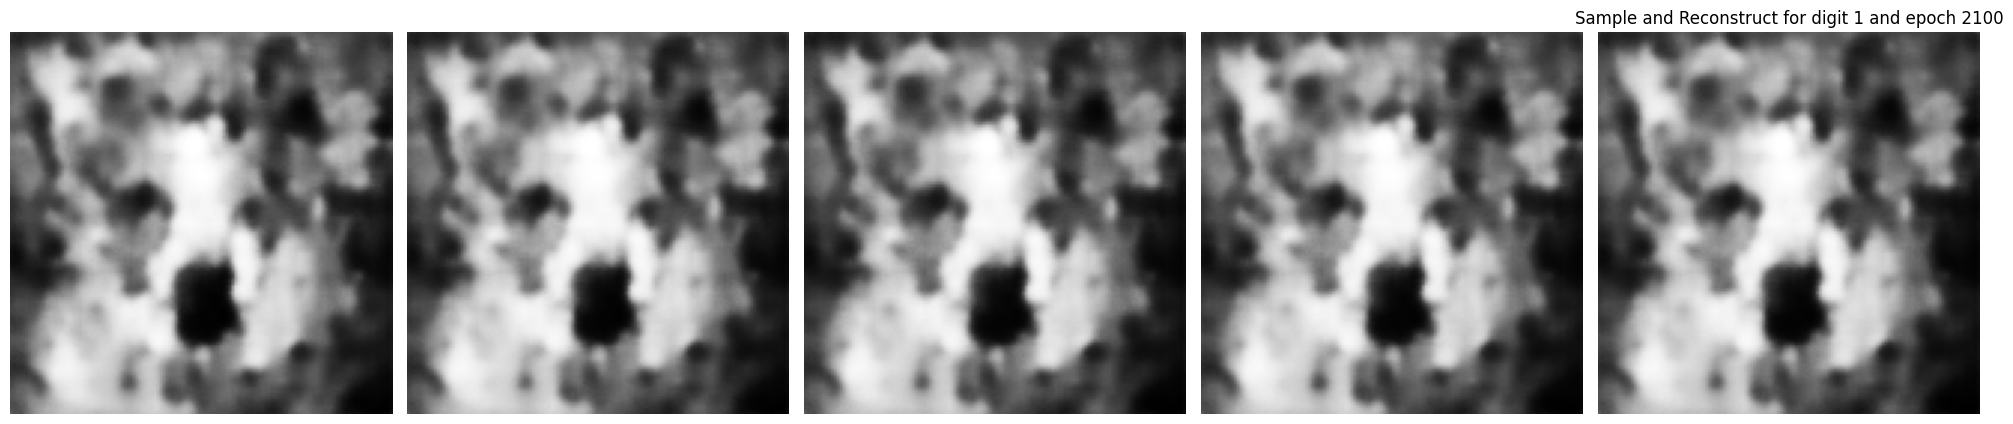

mean = tensor([ 98.9601, 101.0895, 101.2296,  99.7400, 101.5728,  98.8643, 101.8938,
         97.1745,  98.4706, 100.3873,  99.6118, 101.6447,  99.8450, 101.6385,
         98.9461,  98.5822,  99.2612, 100.6771, 100.6751, 101.6324,  97.0162,
        100.7162,  99.9092, 101.3117,  98.5551, 100.1629, 100.1146,  99.2823,
         99.4318, 101.3231, 101.4796,  99.4748, 100.4823,  99.3412,  99.9188,
        101.5850,  99.4424,  99.0933, 101.1521,  99.7372, 100.4478, 101.2355,
        100.1695, 102.1412, 100.1425, 100.7742,  98.8567,  99.9138, 100.1345,
         99.7064,  99.2110, 100.0417,  99.8642, 101.1314,  99.4651, 102.7728,
        100.2412, 100.4033, 100.0804,  99.1982, 101.9166, 102.3050,  99.9948,
        100.7702,  98.0255,  98.9774,  99.7518,  99.3379, 100.1589,  99.2270,
         99.3115,  99.7529,  99.8569, 101.7081,  98.6185, 100.3453,  99.2323,
        101.5734, 101.0271, 101.3445, 100.9534,  99.2434, 100.7397,  97.8445,
        100.6666,  99.5720,  99.3297, 100.4958,  98.4439,

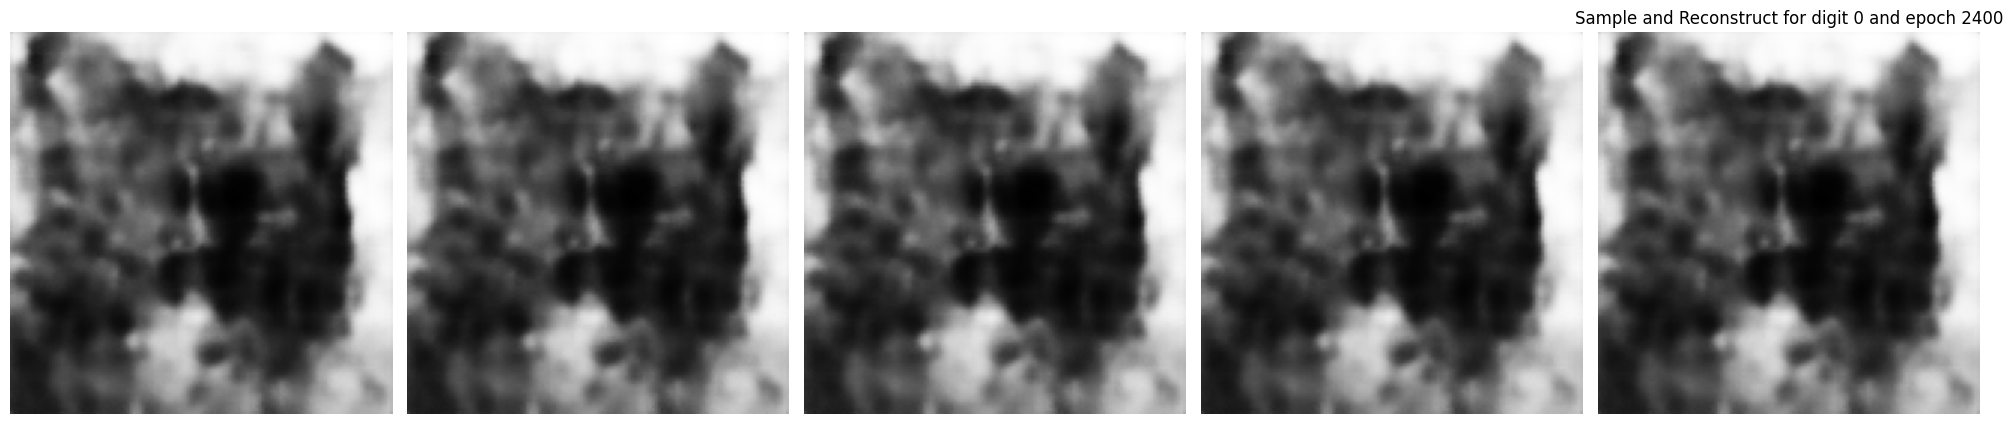

mean = tensor([ 99.0426, 100.9815, 101.3563,  99.6437, 101.5143,  98.9075, 101.9406,
         97.2664,  98.4999, 100.5635,  99.7144, 101.8309,  99.9287, 101.6422,
         98.8556,  98.5122,  99.3552, 100.7117, 100.6515, 101.6483,  97.2949,
        100.6851, 100.1119, 101.3991,  98.4839, 100.1644, 100.2243,  99.1723,
         99.5206, 101.4632, 101.6500,  99.4555, 100.4784,  99.3237,  99.8296,
        101.6846,  99.4285,  99.4462, 100.8790,  99.5571, 100.4346, 101.3753,
        100.0337, 102.0613, 100.2500, 100.9878,  98.6206,  99.8946, 100.0763,
         99.7998,  99.1164, 100.2431,  99.7778, 100.8203,  99.4914, 102.6471,
        100.3487, 100.2855,  99.9686,  99.1144, 101.9769, 102.4292,  99.8877,
        100.3641,  98.1013,  98.8417,  99.7857,  99.3836, 100.4894,  99.2345,
         99.4457,  99.8392, 100.0206, 101.5962,  98.6091, 100.4901,  99.3465,
        101.7460, 101.0811, 101.4019, 101.0369,  99.1705, 100.7369,  97.9496,
        100.7771,  99.5838,  99.5123, 100.7725,  98.2519,

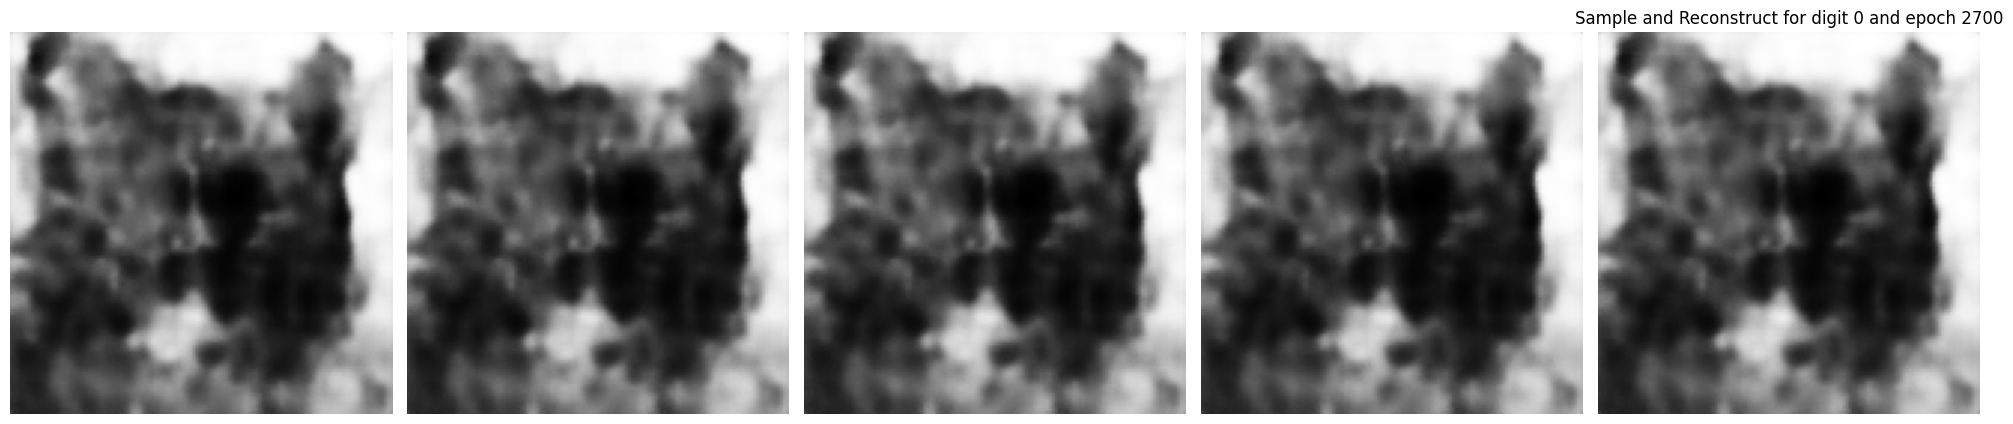

mean = tensor([ 98.8591, 100.9674, 101.2779,  99.4479, 101.7365,  98.8158, 101.8002,
         97.4126,  98.5912, 100.5950,  99.8500, 102.0074,  99.9451, 101.7372,
         98.6482,  98.5487,  99.4433, 100.5688, 100.6225, 101.6561,  97.1653,
        100.5840, 100.0321, 101.6829,  98.5153, 100.0823, 100.0648,  99.1546,
         99.5032, 101.3314, 101.3853,  99.2872, 100.4543,  99.3051,  99.7416,
        101.7531,  99.4066,  99.4061, 100.8310,  99.5942, 100.5583, 101.4529,
        100.1780, 102.1174, 100.3634, 100.6827,  98.5701,  99.7398, 100.1068,
         99.6546,  99.1830,  99.6270,  99.9241, 100.8359,  99.4345, 102.8178,
        100.1962, 100.2521, 100.1002,  99.4650, 101.7677, 102.4003,  99.7655,
        100.2263,  97.8574,  99.1251,  99.6024,  99.5433,  99.9389,  99.3419,
         99.3250,  99.7487,  99.9250, 101.5814,  98.5097, 100.8217,  99.3308,
        101.7215, 101.0899, 101.2498, 100.8683,  99.0126, 100.7847,  98.1354,
        100.9478,  99.6711,  99.5445, 100.7990,  98.3141,

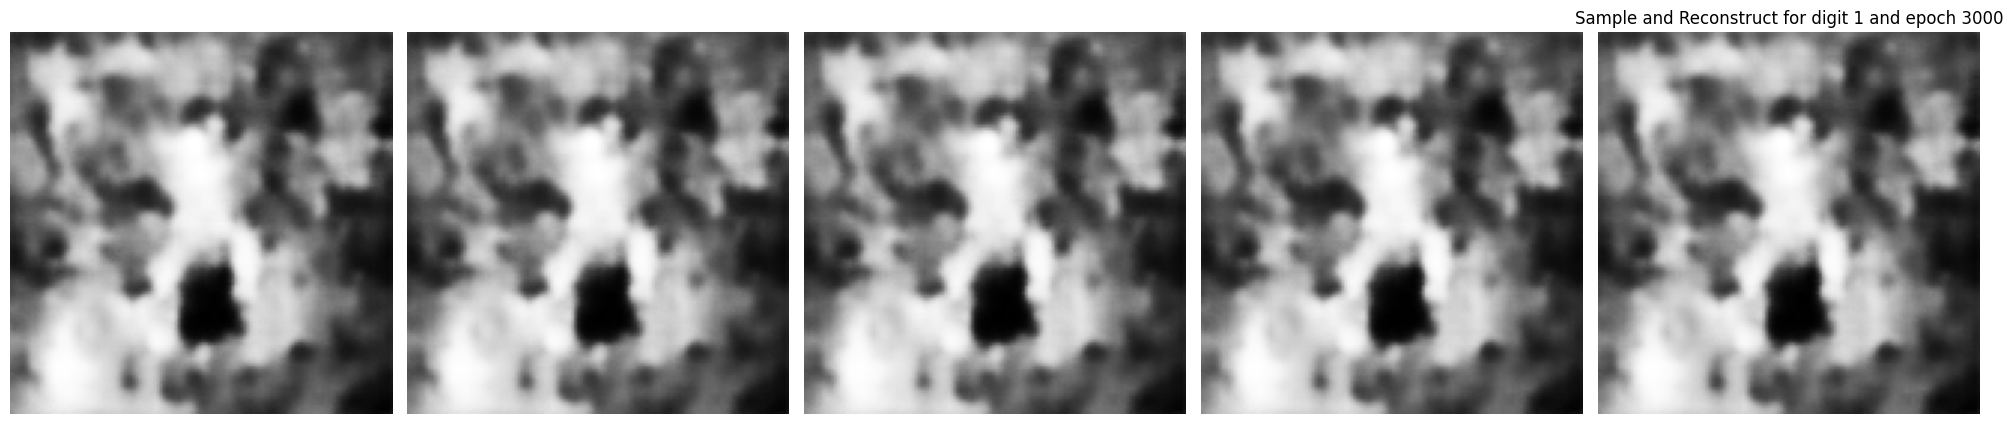

100%|██████████| 3000/3000 [38:53<00:00,  1.29it/s]


In [119]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim_128 = 128
num_trajectories = 1
num_generations = 3000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_128 = shuffle(np.concatenate((final_0_128[:num_0], final_1_128[:num_1]), axis=0))
print(x_data_128.shape)

# repeat for 128
final_var_128 = final_cov_128.diagonal()
mu_0_vals = [torch.tensor(final_mean_128, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_128, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_128, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_128, device, (avg_mean_128, diff_mean_128, final_mean_128), inv_0_128, inv_1_128, (128, 128), latent_dim = latent_dims, add_old_data = 0)

(100, 128)


  0%|          | 0/7000 [00:00<?, ?it/s]

Generation 1


  0%|          | 1/7000 [00:00<1:35:32,  1.22it/s]C:\Users\shrey\AppData\Local\Temp\ipykernel_8452\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
100%|██████████| 7000/7000 [2:21:29<00:00,  2.05s/it]  C:\Users\shrey\AppData\Local\Temp\ipykernel_8452\1100795496.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


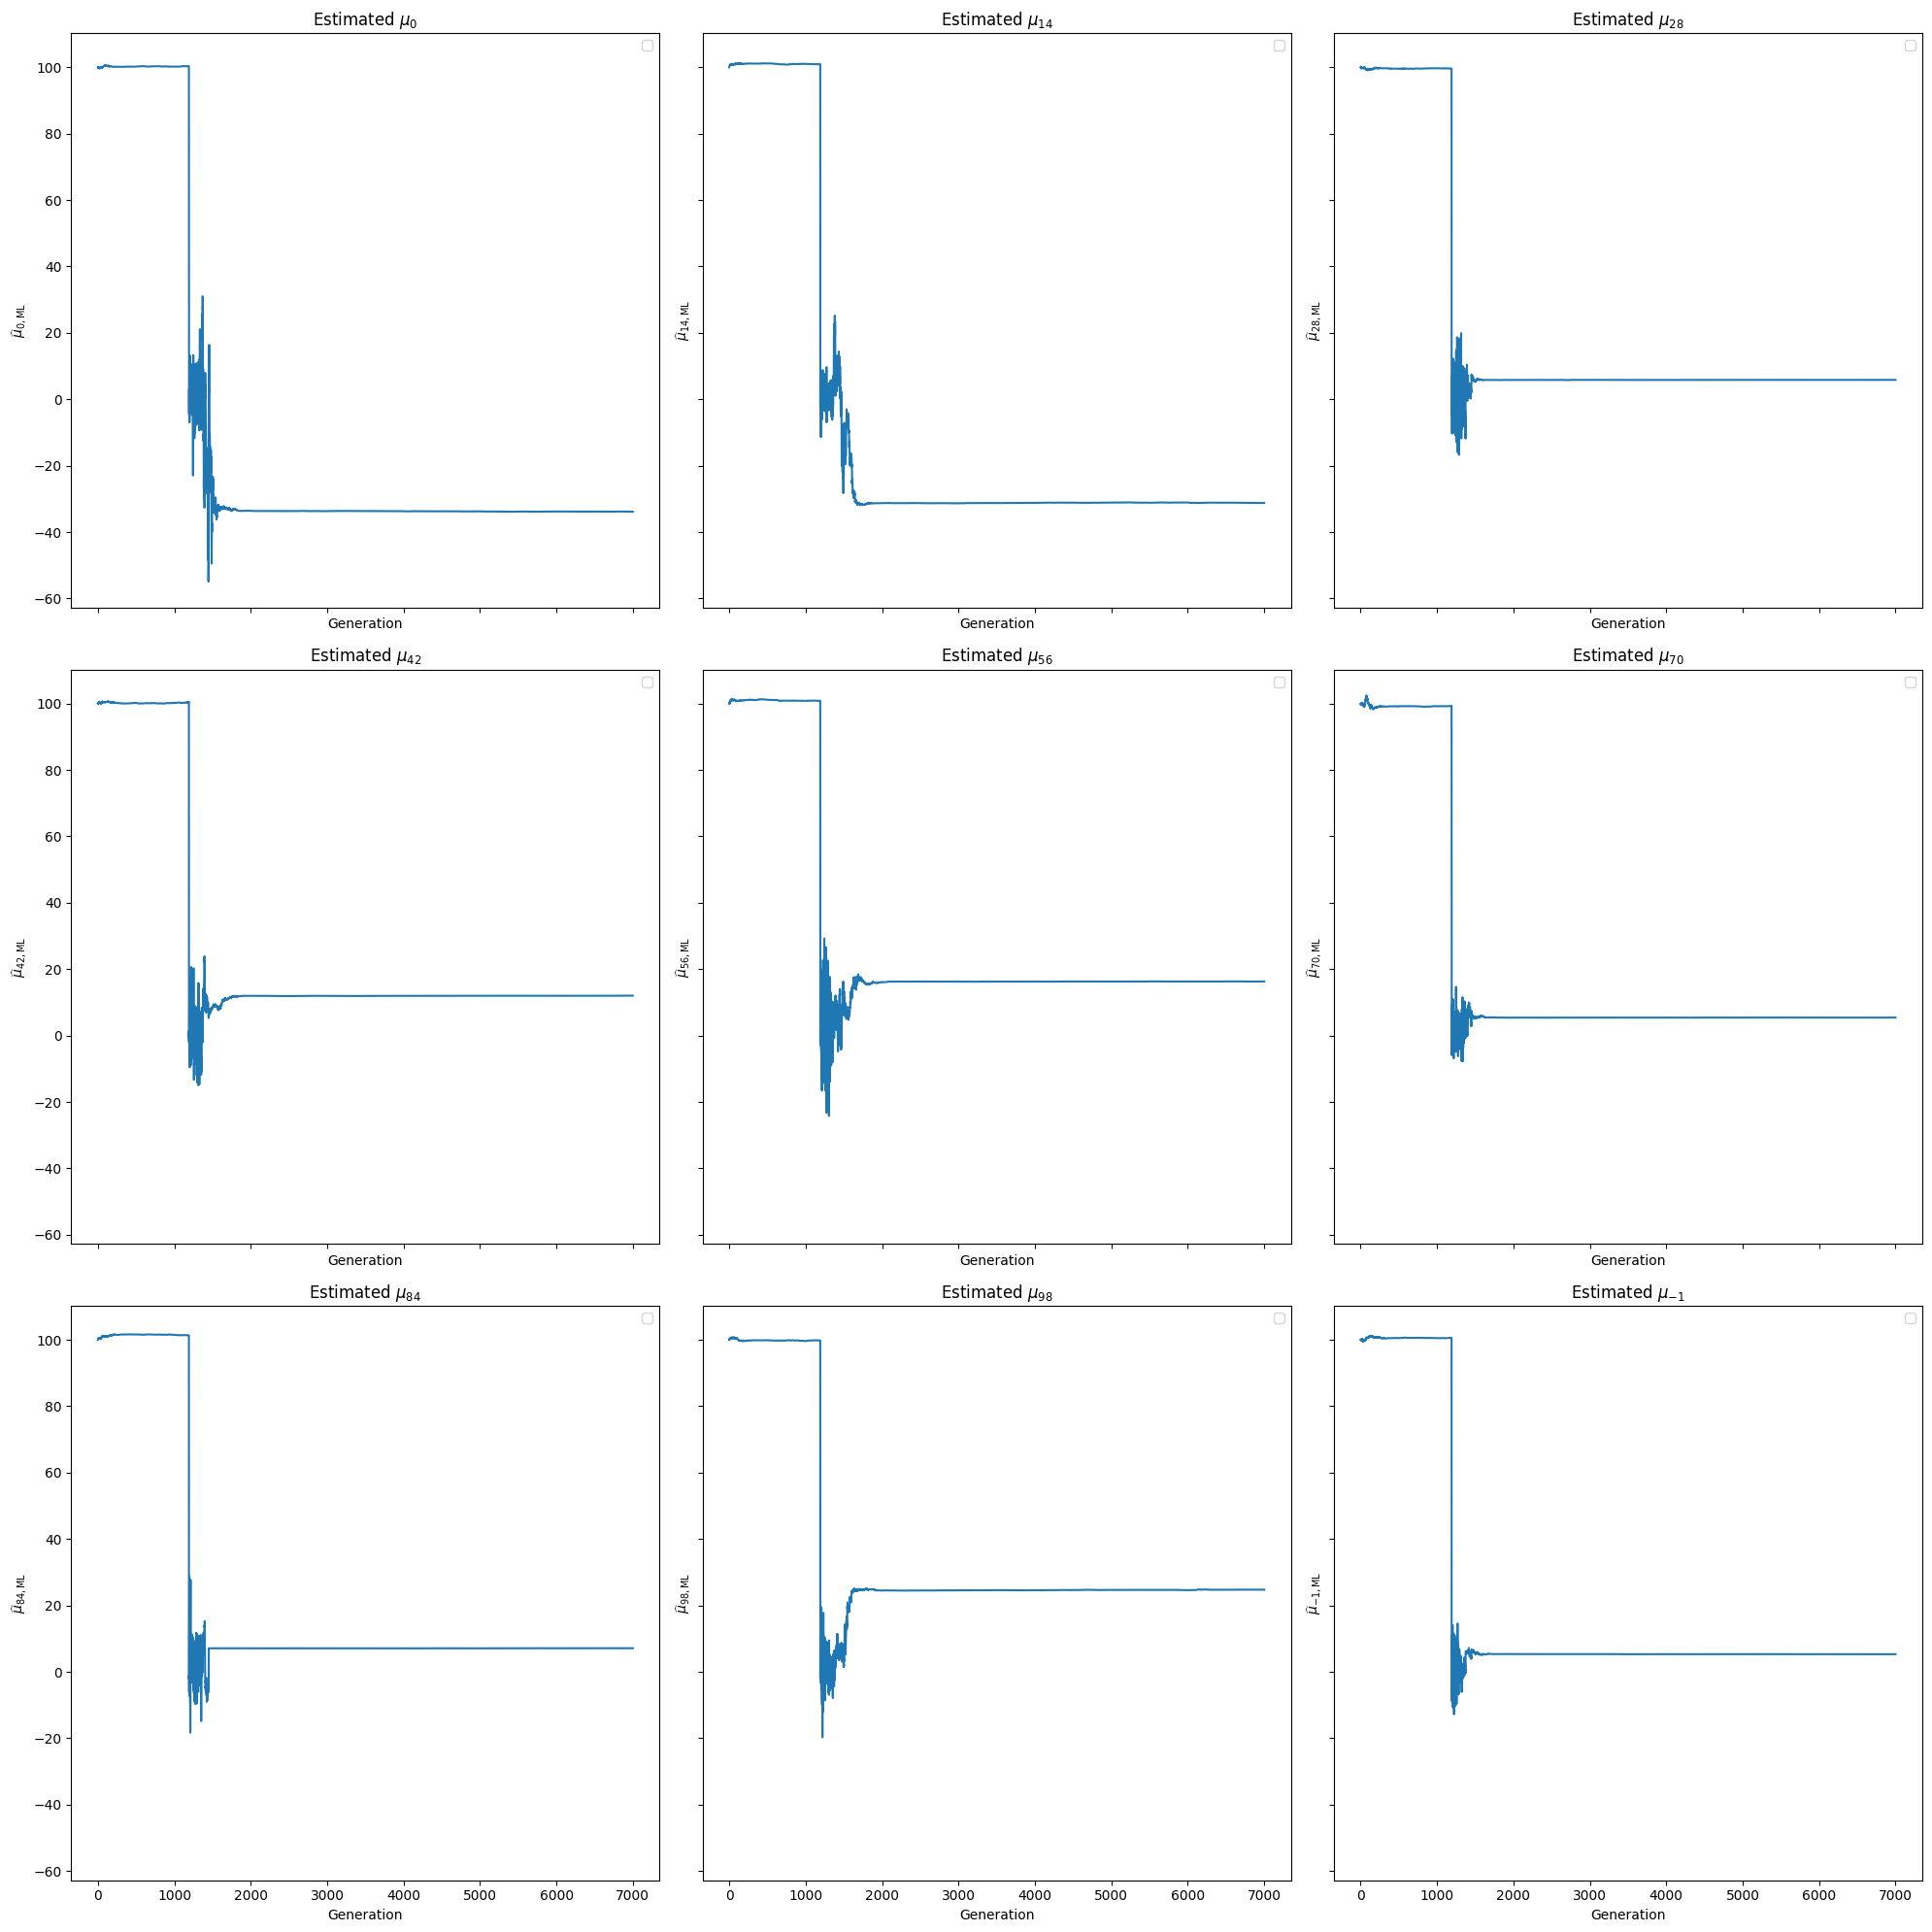

C:\Users\shrey\AppData\Local\Temp\ipykernel_8452\1100795496.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

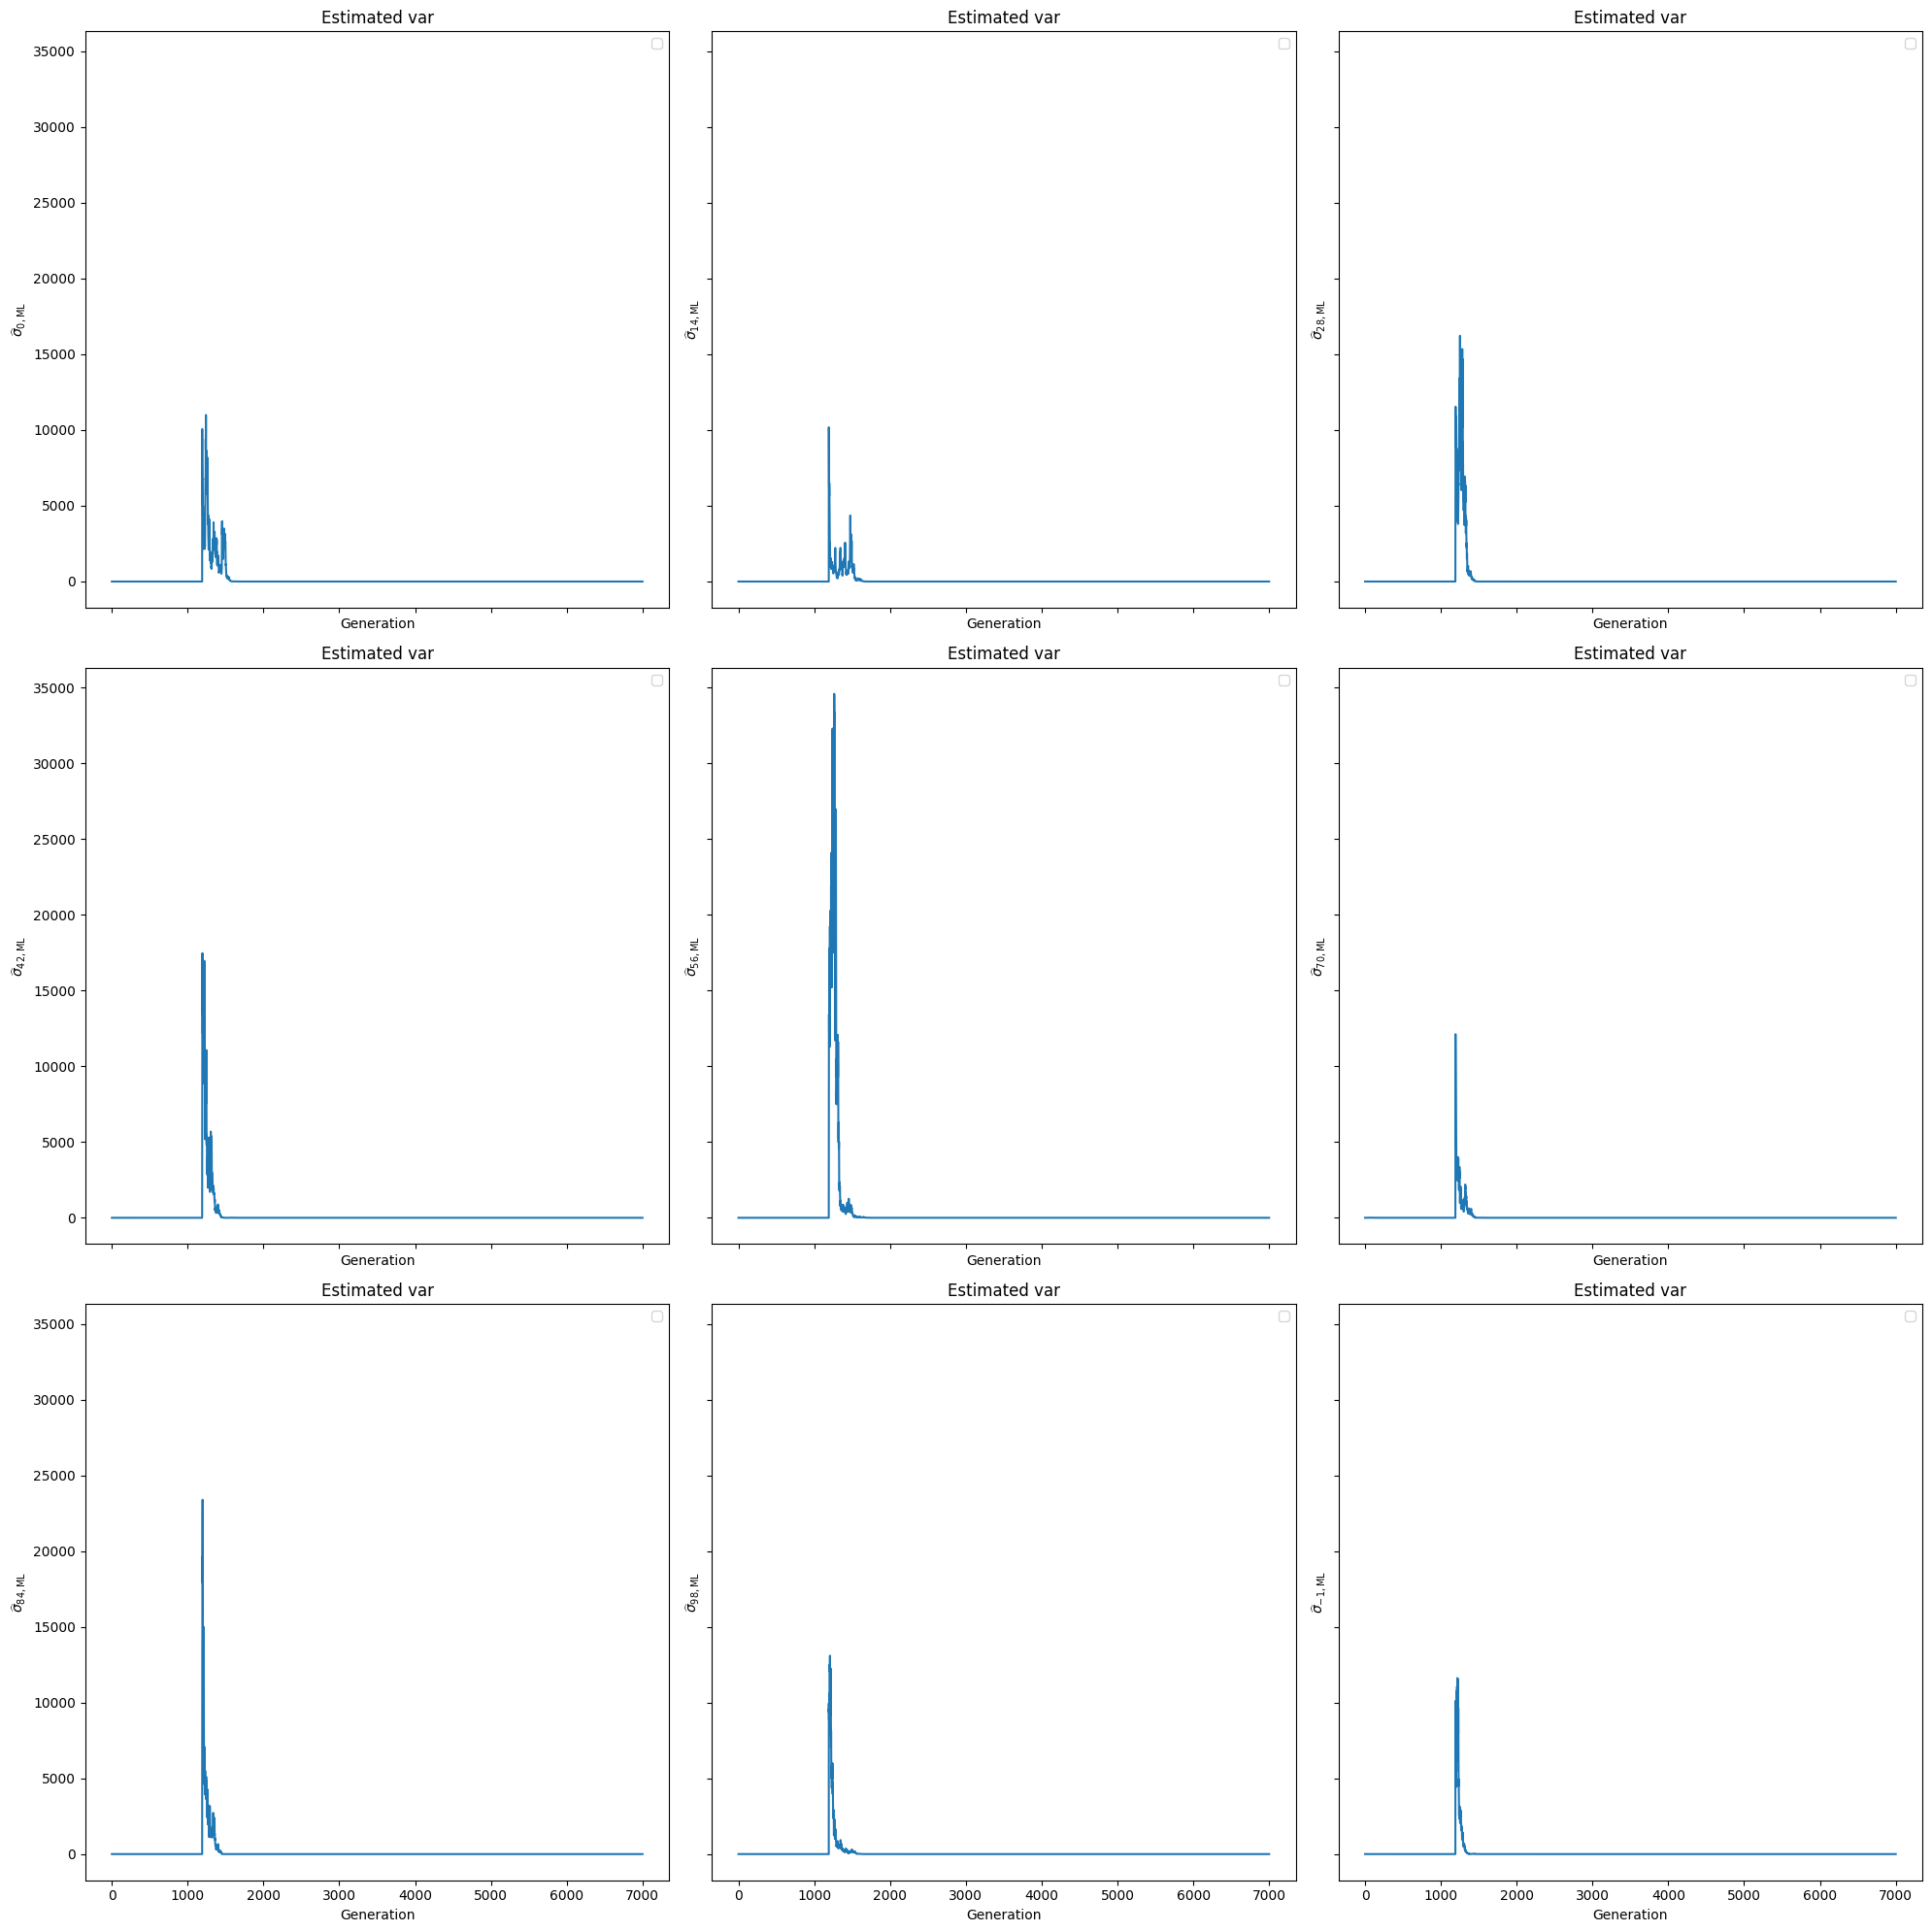

C:\Users\shrey\AppData\Local\Temp\ipykernel_8452\1100795496.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


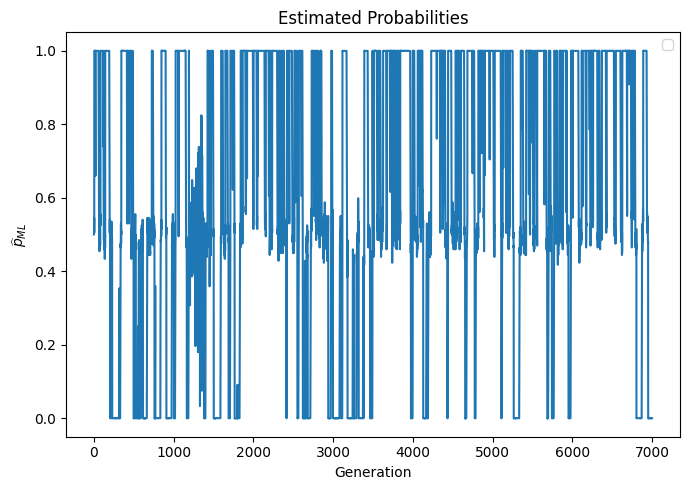

C:\Users\shrey\AppData\Local\Temp\ipykernel_8452\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)


idx_list = [   0  700 1400 2100 2800 3500 4200 4900 5600 6300 7000]
mean = tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100.])
var = tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

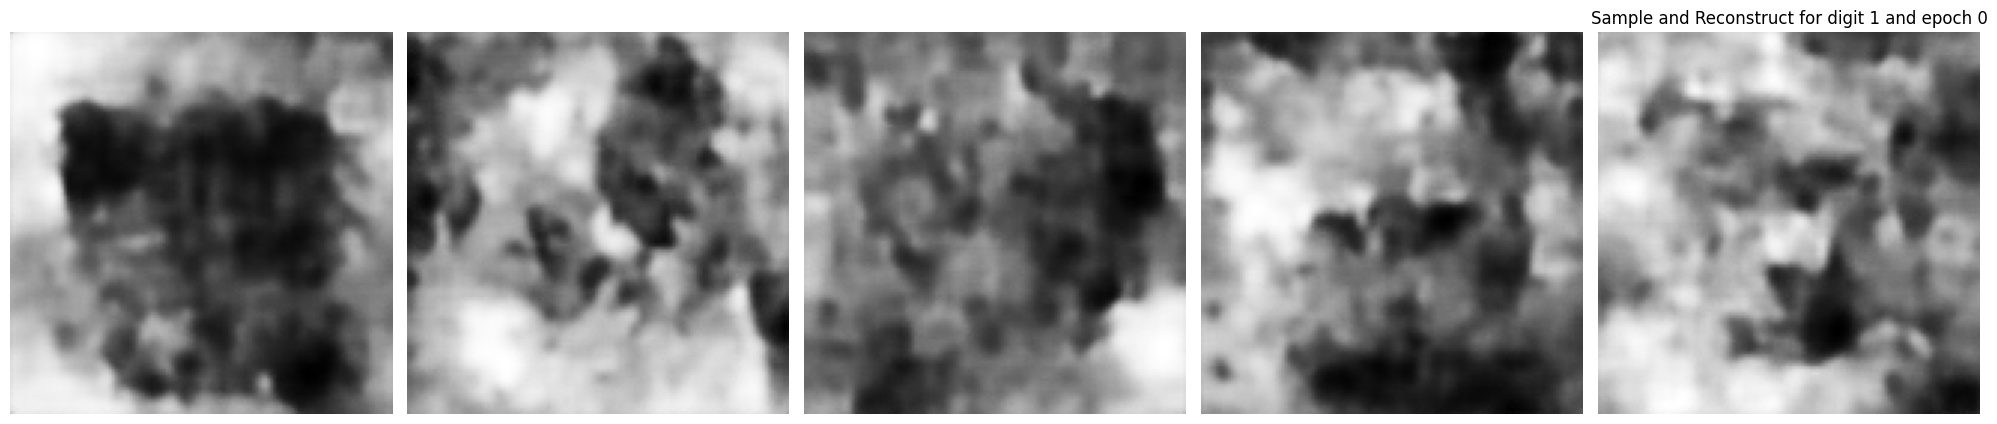

mean = tensor([100.2713,  99.9787, 100.6573, 100.5073,  99.7168, 100.2280,  99.3519,
         99.8744,  99.7297, 101.5271, 100.4518,  99.7415, 100.4490, 104.8410,
        100.8839, 100.1050, 100.3921,  99.3715,  99.4887, 100.5060, 100.5365,
        100.7177,  99.8731, 101.2902,  99.4763,  99.0480,  99.4839,  99.1165,
         99.5348,  98.3036,  98.6989,  99.9408,  99.5654, 101.7214,  98.8045,
         99.5567,  99.5740,  99.0749,  99.6189, 101.8548,  99.7631, 101.6036,
        100.1312,  99.8864, 100.2717, 100.6092, 100.0553, 100.3047, 101.0567,
        100.8354, 100.2972,  99.6227,  99.1673, 100.5994, 100.1482,  99.7541,
        100.8622, 100.5848,  99.2965, 109.8040, 100.2436, 100.2365,  99.6962,
        101.4812, 100.8841, 100.6798,  99.1001,  98.6805, 100.4905, 100.3786,
         99.2074,  99.7073, 101.0333,  99.3378, 100.2344,  99.9738, 101.0709,
        101.6156, 100.4152, 101.8827,  99.2483,  95.3243,  99.9200,  99.8198,
        101.6460, 100.6670,  99.4634,  99.2774,  99.6390,

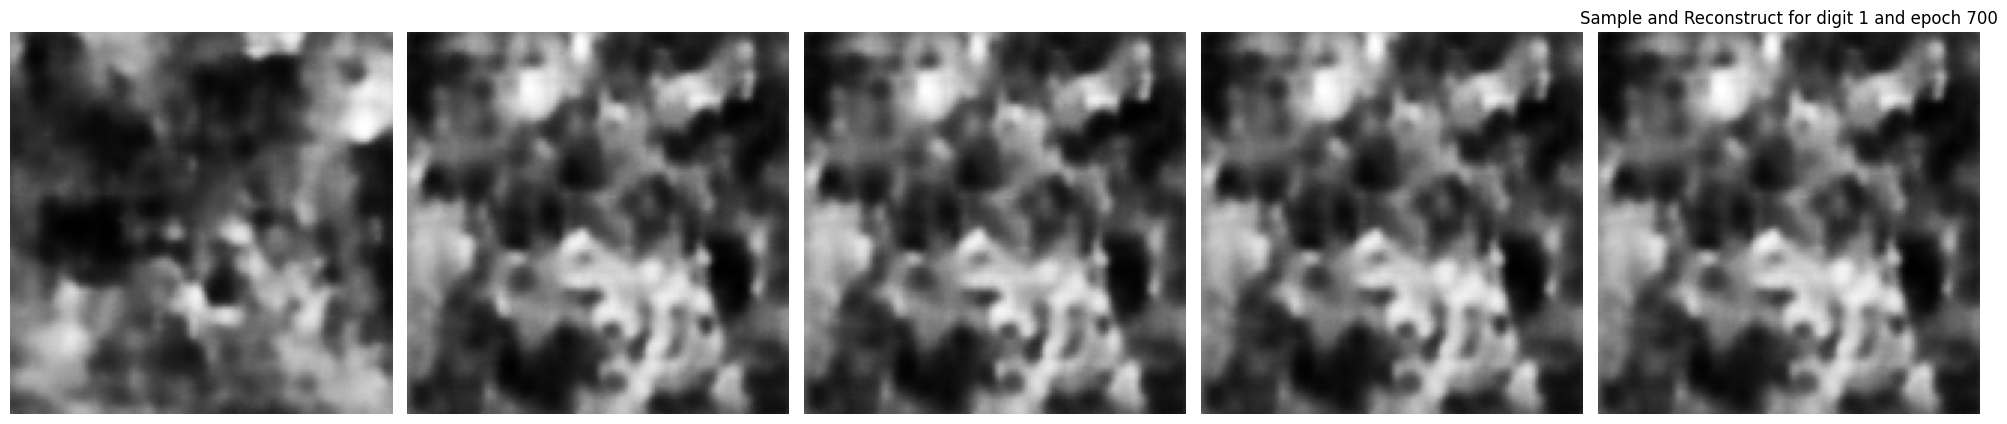

mean = tensor([ 2.5374e+00,  3.8702e+00,  4.8821e+00, -3.7808e+00,  8.7420e+00,
         9.3637e+00,  8.1074e+00,  2.0096e+01, -8.9101e+00,  7.9670e+00,
         4.9563e+00,  1.7266e-02,  1.1753e+01,  7.5176e+00,  6.1804e+00,
         4.4304e+00, -1.2764e+01,  1.2534e+01,  7.5882e+00, -6.2940e+00,
         3.1423e-01, -8.2505e+00,  6.3782e+00,  1.2848e+00,  7.8614e+00,
         5.6437e+00,  6.4751e+00,  6.1475e+00,  4.6246e+00,  3.1956e+00,
         4.5763e+00,  7.2336e+00,  8.7363e+00,  2.2253e+00,  5.0780e+00,
         1.3238e+01, -1.4270e+01,  6.6577e+00,  1.1346e+01,  9.0797e+00,
         1.3007e+01,  5.8201e+00,  8.9802e+00,  3.5669e-01,  5.5585e+00,
         4.1965e+00,  8.8535e+00,  6.4589e+00, -8.1946e+00, -2.7504e+01,
         6.8728e+00,  8.8574e+00, -4.1588e+00,  4.1576e+00,  5.0901e+00,
         9.3671e+00,  6.8463e+00, -3.1548e+00,  4.2831e+00,  5.5233e+00,
         3.5338e+00,  9.1239e+00,  3.6488e+00,  1.2944e+01,  5.2214e+00,
         2.4675e+00,  4.4021e+00, -1.3926e+0

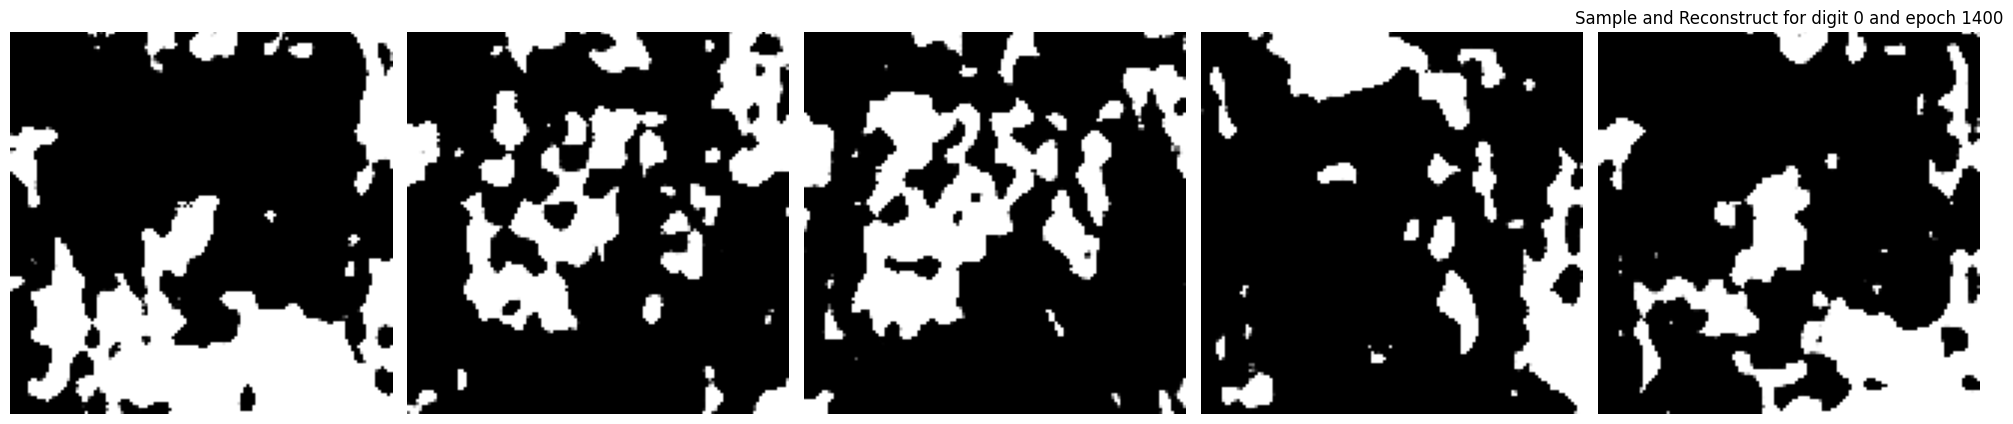

mean = tensor([-3.3646e+01,  9.4856e+00,  3.9933e+00,  1.9478e+02, -1.9368e+02,
         1.1219e+01,  1.4981e+01, -1.5046e+02, -4.4972e+01, -5.6214e+00,
         4.9811e+00, -1.9228e+01,  1.0885e+01,  2.7225e+00, -3.1232e+01,
        -5.5490e+01,  1.7446e+01,  7.2414e+00,  1.0503e+01,  3.0085e+01,
        -2.6011e+01, -3.2756e+01,  6.0206e+00, -3.4920e+00, -7.2272e+00,
         5.4702e+00,  1.3929e+01,  6.5498e+00,  5.8368e+00,  1.5227e+01,
        -4.3634e+01, -1.0644e+00, -3.5434e+00,  4.1999e+00,  2.8431e+01,
         6.0371e+00,  2.9573e+01,  6.2097e+00,  2.1849e+01, -1.3148e+01,
         3.7466e+00, -5.5346e+00,  1.1951e+01,  2.8738e+01,  1.6255e+01,
         7.5053e+00,  7.5141e-01,  1.3512e+01, -1.5763e+01, -5.1158e+01,
         1.9325e+01, -1.9407e+01, -1.8905e+01,  9.8905e+00,  7.9261e+00,
        -6.4754e+01,  1.6248e+01, -1.9973e+01,  1.3087e+02, -3.5176e-01,
        -1.9742e+01,  1.2639e+02,  2.6918e+01,  1.2527e+01,  7.5996e+00,
        -2.7078e+01,  7.0041e+00, -1.0827e+0

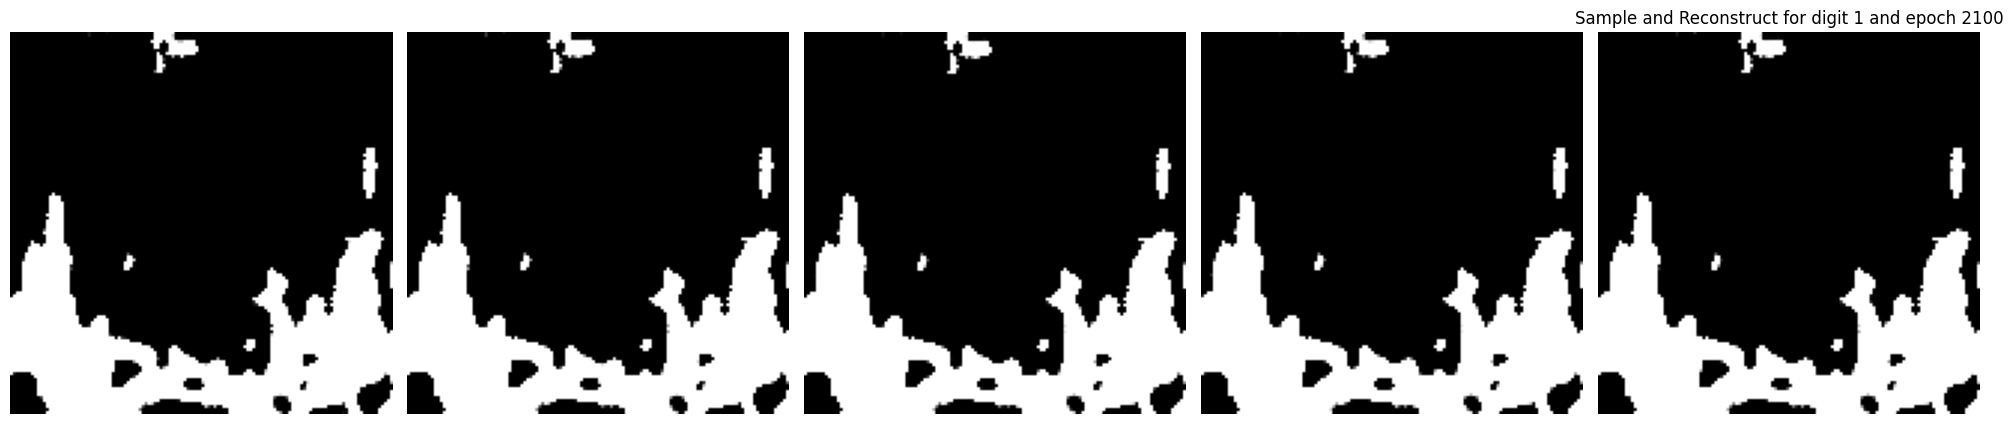

mean = tensor([-3.3691e+01,  9.2479e+00,  3.9936e+00,  1.9453e+02, -1.9416e+02,
         1.1123e+01,  1.5100e+01, -1.5089e+02, -4.4937e+01, -5.6201e+00,
         4.9398e+00, -1.9186e+01,  1.0844e+01,  3.0122e+00, -3.1275e+01,
        -5.5723e+01,  1.7552e+01,  7.2400e+00,  1.0513e+01,  2.9928e+01,
        -2.5991e+01, -3.2810e+01,  6.0130e+00, -3.4374e+00, -7.2466e+00,
         5.4658e+00,  1.3974e+01,  6.5207e+00,  5.8511e+00,  1.5194e+01,
        -4.3995e+01, -1.0771e+00, -3.5556e+00,  4.1999e+00,  2.8271e+01,
         5.9737e+00,  2.9599e+01,  6.2116e+00,  2.1875e+01, -1.3140e+01,
         3.8132e+00, -5.5221e+00,  1.1964e+01,  2.8821e+01,  1.6269e+01,
         7.4604e+00,  6.6623e-01,  1.3489e+01, -1.5781e+01, -5.1037e+01,
         1.9370e+01, -1.9415e+01, -1.9056e+01,  9.8769e+00,  7.9626e+00,
        -6.5004e+01,  1.6255e+01, -1.9686e+01,  1.3056e+02, -3.3388e-01,
        -1.9695e+01,  1.2812e+02,  2.6894e+01,  1.2555e+01,  7.6056e+00,
        -2.6978e+01,  6.9907e+00, -1.0832e+0

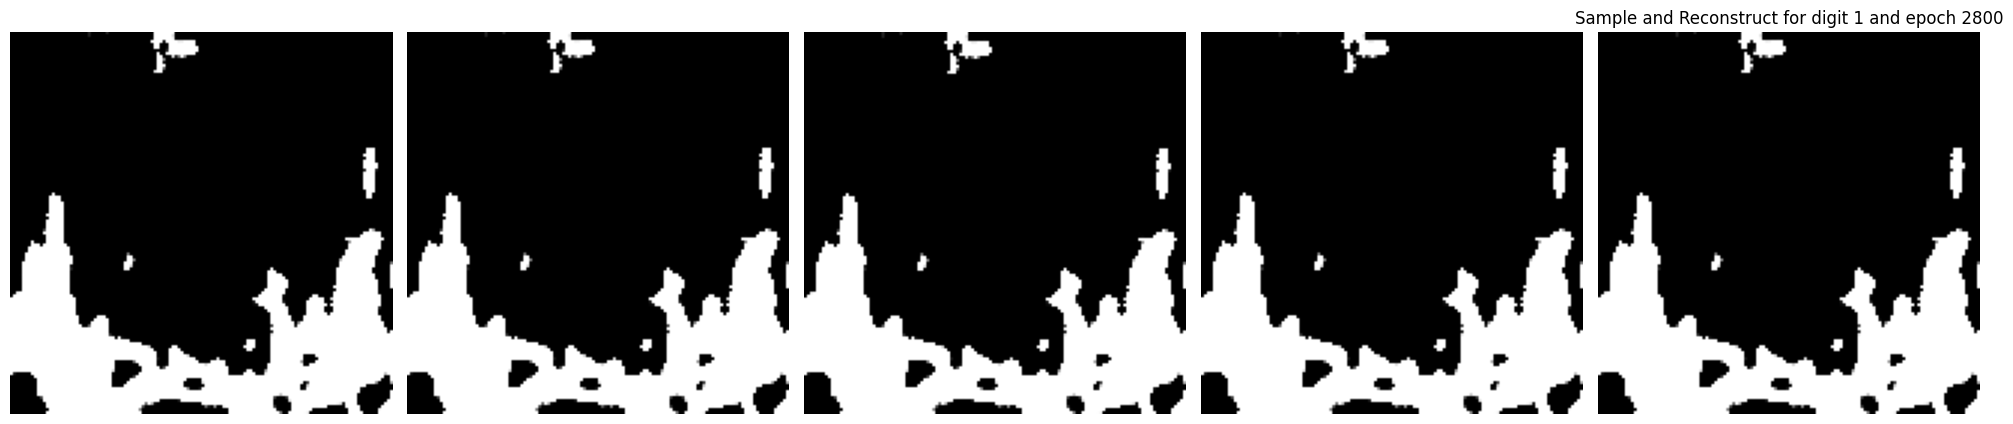

mean = tensor([-3.3657e+01,  9.2666e+00,  3.9870e+00,  1.9417e+02, -1.9421e+02,
         1.1141e+01,  1.5051e+01, -1.5062e+02, -4.5063e+01, -5.6255e+00,
         4.9328e+00, -1.9191e+01,  1.0827e+01,  3.0165e+00, -3.1245e+01,
        -5.5784e+01,  1.7582e+01,  7.2544e+00,  1.0501e+01,  2.9894e+01,
        -2.5959e+01, -3.2777e+01,  6.0261e+00, -3.4362e+00, -7.2627e+00,
         5.4688e+00,  1.3953e+01,  6.5385e+00,  5.8300e+00,  1.5178e+01,
        -4.3835e+01, -1.0618e+00, -3.5670e+00,  4.2200e+00,  2.8298e+01,
         5.9431e+00,  2.9546e+01,  6.2214e+00,  2.1886e+01, -1.3229e+01,
         3.8092e+00, -5.5385e+00,  1.1926e+01,  2.8852e+01,  1.6271e+01,
         7.4578e+00,  6.6773e-01,  1.3479e+01, -1.5806e+01, -5.1089e+01,
         1.9322e+01, -1.9445e+01, -1.9015e+01,  9.8834e+00,  7.9715e+00,
        -6.5049e+01,  1.6258e+01, -1.9693e+01,  1.3073e+02, -3.2827e-01,
        -1.9641e+01,  1.2795e+02,  2.7022e+01,  1.2558e+01,  7.5964e+00,
        -2.7017e+01,  6.9208e+00, -1.0830e+0

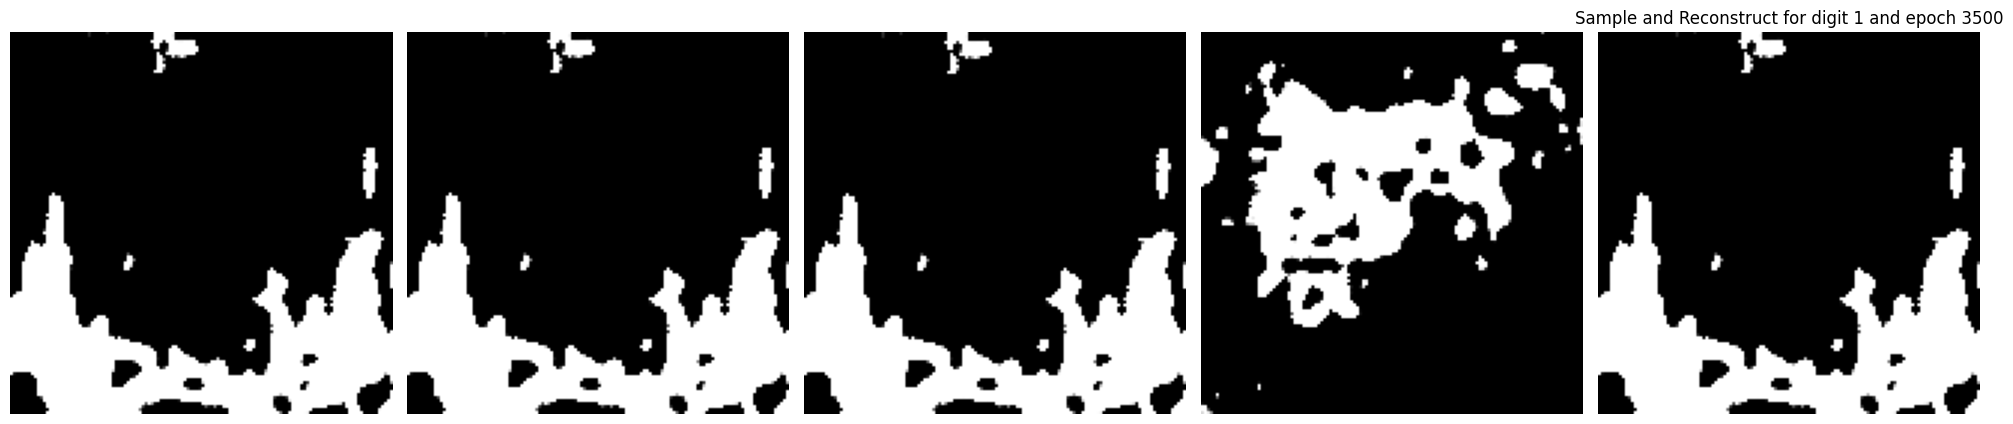

mean = tensor([-3.3710e+01,  9.2491e+00,  4.0073e+00,  1.9371e+02, -1.9410e+02,
         1.1071e+01,  1.5029e+01, -1.5074e+02, -4.4999e+01, -5.6233e+00,
         4.9281e+00, -1.9168e+01,  1.0801e+01,  2.9863e+00, -3.1121e+01,
        -5.5931e+01,  1.7563e+01,  7.2309e+00,  1.0498e+01,  2.9908e+01,
        -2.5954e+01, -3.2659e+01,  6.0421e+00, -3.4211e+00, -7.2433e+00,
         5.4530e+00,  1.3992e+01,  6.5365e+00,  5.8388e+00,  1.5187e+01,
        -4.3832e+01, -1.0654e+00, -3.5759e+00,  4.2159e+00,  2.8259e+01,
         5.9426e+00,  2.9591e+01,  6.2045e+00,  2.1864e+01, -1.3254e+01,
         3.8091e+00, -5.5252e+00,  1.2000e+01,  2.8726e+01,  1.6305e+01,
         7.4455e+00,  6.8086e-01,  1.3468e+01, -1.5831e+01, -5.1063e+01,
         1.9367e+01, -1.9447e+01, -1.8955e+01,  9.8787e+00,  7.9482e+00,
        -6.5152e+01,  1.6255e+01, -1.9628e+01,  1.3045e+02, -3.4516e-01,
        -1.9612e+01,  1.2750e+02,  2.7032e+01,  1.2544e+01,  7.6011e+00,
        -2.7100e+01,  6.8951e+00, -1.0828e+0

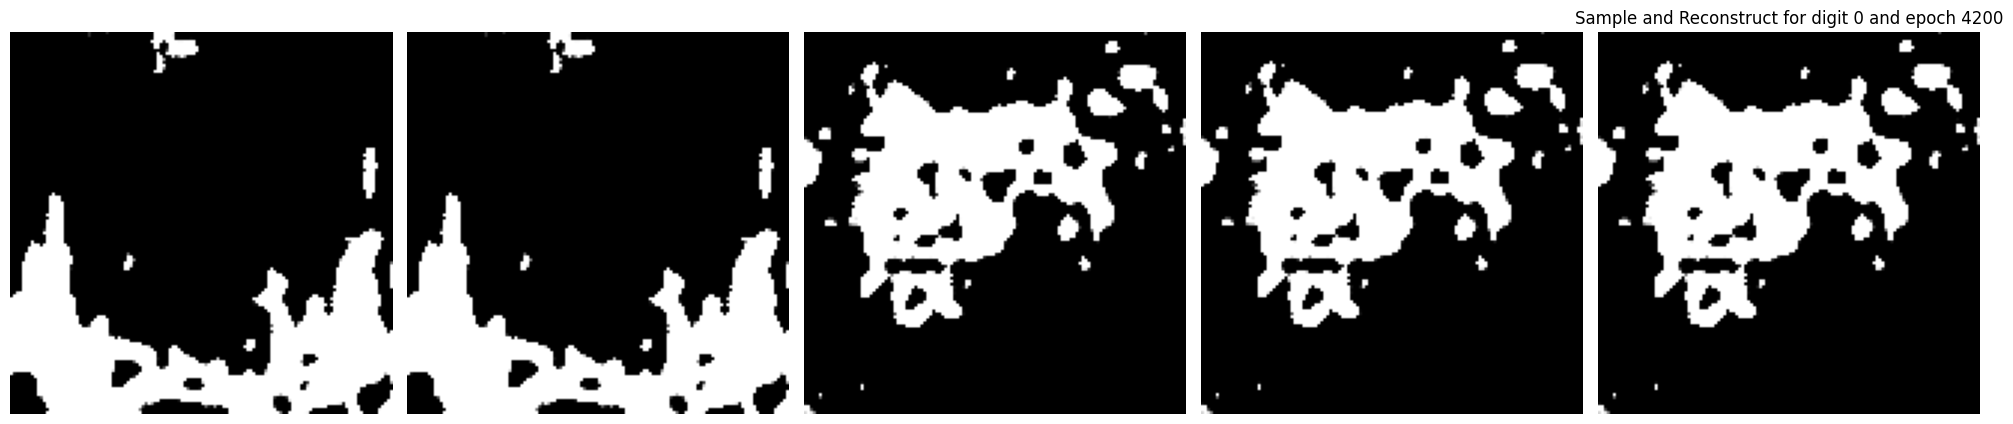

mean = tensor([-3.3772e+01,  9.2897e+00,  3.9990e+00,  1.9366e+02, -1.9443e+02,
         1.1091e+01,  1.5007e+01, -1.5054e+02, -4.4954e+01, -5.6422e+00,
         4.9254e+00, -1.9054e+01,  1.0772e+01,  2.9874e+00, -3.1123e+01,
        -5.5682e+01,  1.7534e+01,  7.2349e+00,  1.0526e+01,  2.9945e+01,
        -2.5940e+01, -3.2723e+01,  6.0437e+00, -3.4160e+00, -7.2506e+00,
         5.4658e+00,  1.3995e+01,  6.5572e+00,  5.8433e+00,  1.5115e+01,
        -4.3809e+01, -1.0528e+00, -3.5951e+00,  4.2235e+00,  2.8204e+01,
         5.9332e+00,  2.9628e+01,  6.1960e+00,  2.1811e+01, -1.3270e+01,
         3.8484e+00, -5.5263e+00,  1.1988e+01,  2.8744e+01,  1.6277e+01,
         7.4821e+00,  6.9537e-01,  1.3429e+01, -1.5804e+01, -5.1044e+01,
         1.9402e+01, -1.9393e+01, -1.8979e+01,  9.8620e+00,  7.9586e+00,
        -6.5129e+01,  1.6268e+01, -1.9636e+01,  1.3019e+02, -3.3234e-01,
        -1.9530e+01,  1.2769e+02,  2.6967e+01,  1.2571e+01,  7.5822e+00,
        -2.7178e+01,  6.9044e+00, -1.0842e+0

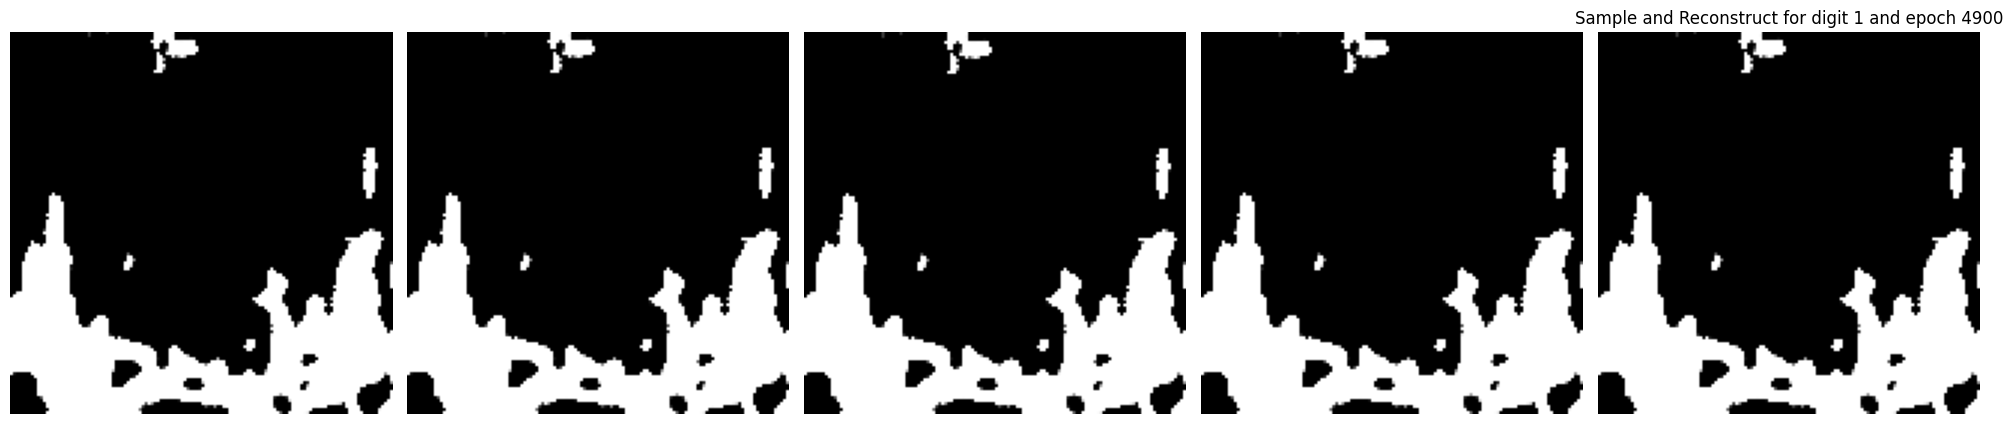

mean = tensor([-3.3803e+01,  9.2987e+00,  3.9915e+00,  1.9396e+02, -1.9374e+02,
         1.1082e+01,  1.4980e+01, -1.5097e+02, -4.4872e+01, -5.6343e+00,
         4.9158e+00, -1.9006e+01,  1.0796e+01,  2.9688e+00, -3.1084e+01,
        -5.5739e+01,  1.7499e+01,  7.2301e+00,  1.0500e+01,  3.0127e+01,
        -2.5972e+01, -3.2780e+01,  6.0601e+00, -3.4144e+00, -7.2634e+00,
         5.4694e+00,  1.4007e+01,  6.5771e+00,  5.8389e+00,  1.5118e+01,
        -4.3807e+01, -1.0619e+00, -3.5628e+00,  4.2324e+00,  2.8241e+01,
         5.9175e+00,  2.9679e+01,  6.1849e+00,  2.1759e+01, -1.3264e+01,
         3.8523e+00, -5.5608e+00,  1.2005e+01,  2.8675e+01,  1.6293e+01,
         7.5036e+00,  7.0206e-01,  1.3376e+01, -1.5820e+01, -5.0999e+01,
         1.9437e+01, -1.9388e+01, -1.8981e+01,  9.8597e+00,  7.9270e+00,
        -6.5039e+01,  1.6310e+01, -1.9606e+01,  1.2984e+02, -3.2561e-01,
        -1.9510e+01,  1.2749e+02,  2.7071e+01,  1.2570e+01,  7.6019e+00,
        -2.7117e+01,  6.8943e+00, -1.0838e+0

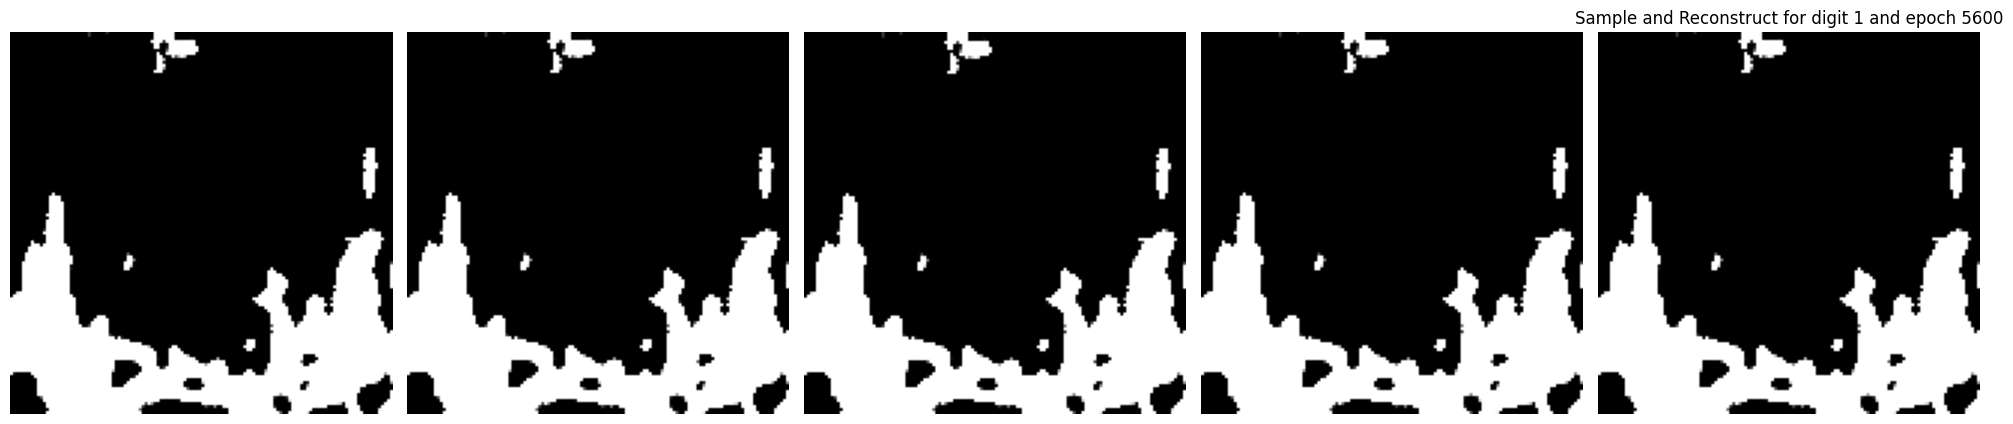

mean = tensor([-3.3826e+01,  9.2697e+00,  3.9873e+00,  1.9306e+02, -1.9266e+02,
         1.1089e+01,  1.4981e+01, -1.5064e+02, -4.4911e+01, -5.6503e+00,
         4.9288e+00, -1.9001e+01,  1.0797e+01,  2.9777e+00, -3.1139e+01,
        -5.5492e+01,  1.7486e+01,  7.2410e+00,  1.0523e+01,  3.0145e+01,
        -2.6006e+01, -3.2867e+01,  6.0557e+00, -3.4283e+00, -7.2531e+00,
         5.4760e+00,  1.3968e+01,  6.5805e+00,  5.8449e+00,  1.5094e+01,
        -4.3919e+01, -1.0449e+00, -3.5604e+00,  4.2225e+00,  2.8251e+01,
         5.9302e+00,  2.9744e+01,  6.1998e+00,  2.1748e+01, -1.3255e+01,
         3.8611e+00, -5.5404e+00,  1.2002e+01,  2.8740e+01,  1.6293e+01,
         7.4944e+00,  7.1205e-01,  1.3351e+01, -1.5813e+01, -5.0904e+01,
         1.9503e+01, -1.9363e+01, -1.8940e+01,  9.8743e+00,  7.9117e+00,
        -6.5095e+01,  1.6287e+01, -1.9587e+01,  1.2969e+02, -3.1987e-01,
        -1.9483e+01,  1.2741e+02,  2.7112e+01,  1.2571e+01,  7.6231e+00,
        -2.7024e+01,  6.8705e+00, -1.0836e+0

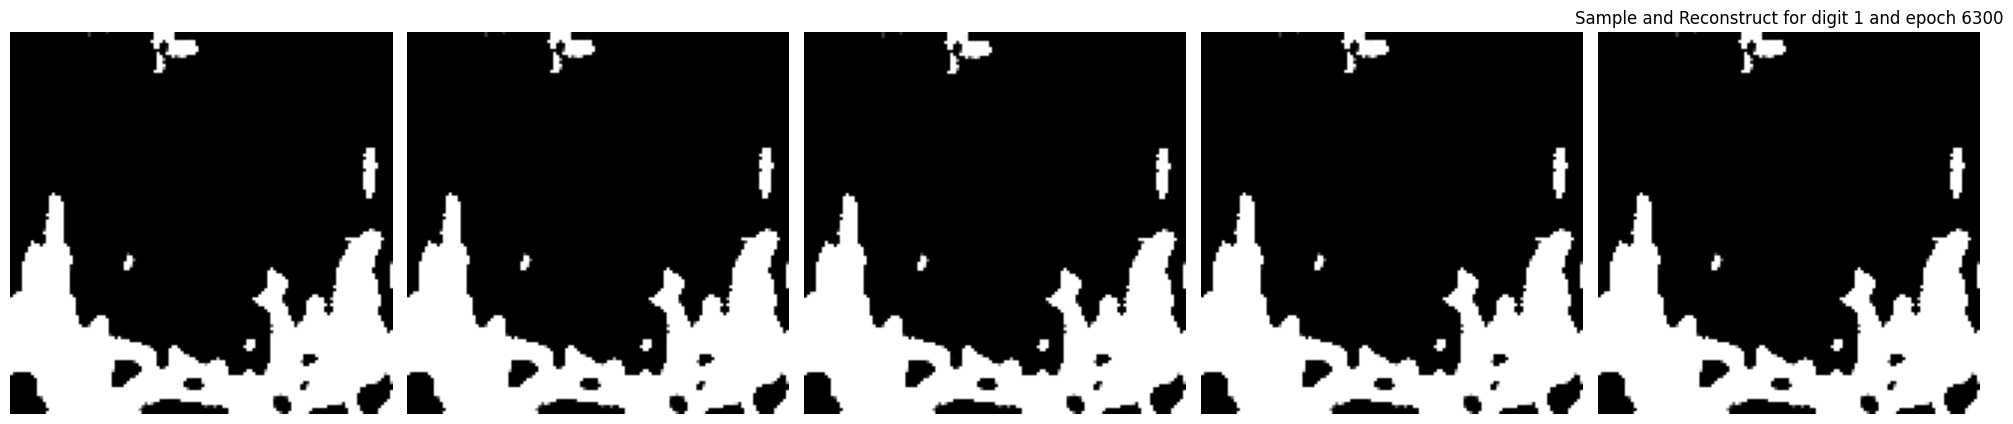

mean = tensor([-3.3870e+01,  9.2906e+00,  3.9819e+00,  1.9335e+02, -1.9269e+02,
         1.1122e+01,  1.5026e+01, -1.5062e+02, -4.5081e+01, -5.6582e+00,
         4.9409e+00, -1.8927e+01,  1.0802e+01,  2.9539e+00, -3.1195e+01,
        -5.5813e+01,  1.7463e+01,  7.2473e+00,  1.0549e+01,  3.0085e+01,
        -2.6046e+01, -3.2875e+01,  6.0536e+00, -3.4358e+00, -7.2420e+00,
         5.4515e+00,  1.3954e+01,  6.6234e+00,  5.8561e+00,  1.5096e+01,
        -4.3789e+01, -1.0452e+00, -3.5691e+00,  4.2307e+00,  2.8342e+01,
         5.9550e+00,  2.9882e+01,  6.1992e+00,  2.1731e+01, -1.3280e+01,
         3.8489e+00, -5.5280e+00,  1.2030e+01,  2.8788e+01,  1.6287e+01,
         7.4868e+00,  7.2279e-01,  1.3374e+01, -1.5779e+01, -5.0875e+01,
         1.9487e+01, -1.9338e+01, -1.8962e+01,  9.8938e+00,  7.8928e+00,
        -6.5152e+01,  1.6299e+01, -1.9657e+01,  1.2966e+02, -3.0894e-01,
        -1.9473e+01,  1.2723e+02,  2.7061e+01,  1.2531e+01,  7.6235e+00,
        -2.7047e+01,  6.8677e+00, -1.0858e+0

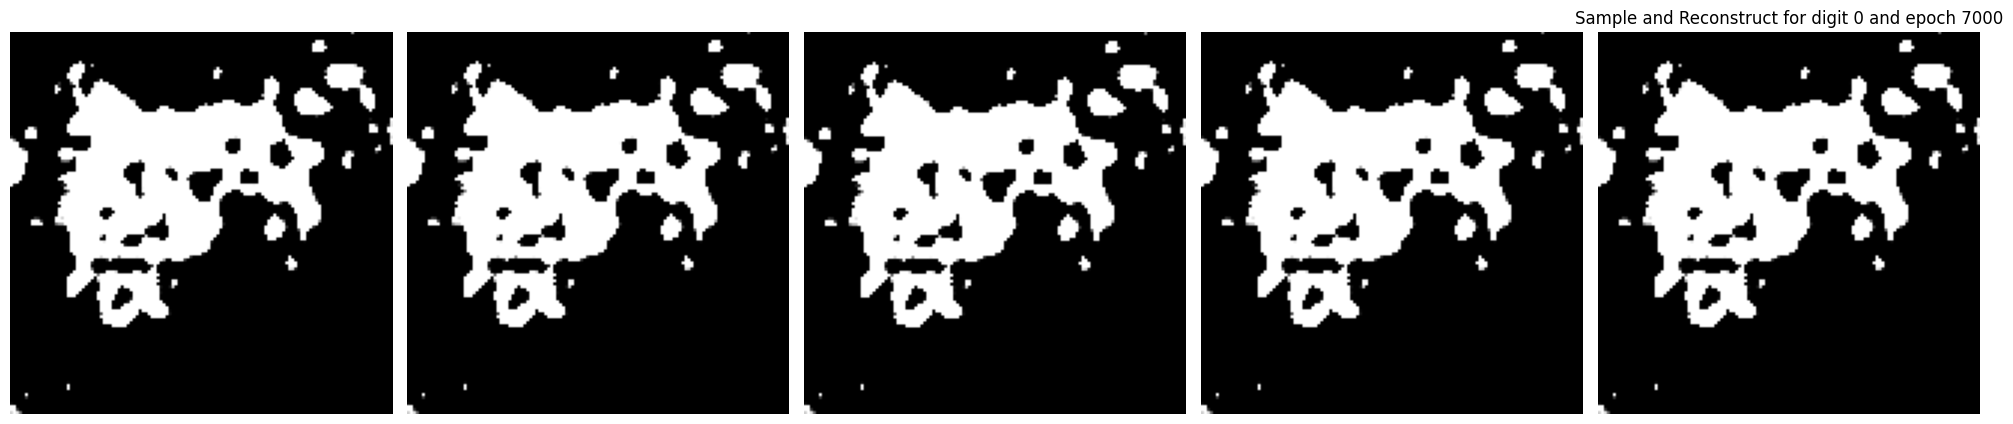

100%|██████████| 7000/7000 [2:21:38<00:00,  1.21s/it]


In [25]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim_128 = 128
num_trajectories = 1
num_generations = 7000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_128 = shuffle(np.concatenate((final_0_128[:num_0], final_1_128[:num_1]), axis=0))
print(x_data_128.shape)

# repeat for 128
final_var_128 = final_cov_128.diagonal()
mu_0_vals = [torch.tensor(final_mean_128, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_128, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_128, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_128, device, (avg_mean_128, diff_mean_128, final_mean_128), inv_0_128, inv_1_128, (128, 128), latent_dim = latent_dims, add_old_data = 0)

In [ ]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim_128 = 128
num_trajectories = 1
num_generations = 10
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_128 = shuffle(np.concatenate((cat_encodings[:num_0], dog_encodings[:num_1]), axis=0))
print(x_data_128.shape)

# repeat for 128
final_var_128 = final_cov_128.diagonal()
mu_0_vals = [torch.tensor(final_mean_128, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_128, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_128, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_128, device, (avg_mean_128, diff_mean_128, final_mean_128), inv_0_128, inv_1_128, (128, 128), latent_dim = latent_dims, add_old_data = 0)